<a href="https://colab.research.google.com/github/Janekao64/NLP_Write_me_P8/blob/main/Project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Section I. Data Preparation.*




For my project I use Google Colab. I mount Google Drive in Google Colab  to access datasets and pre-trained models stored in Google Drive without needing to upload them every time.
The first step is to import the `drive` module from the `google.colab` package. This module provides functions to interact with Google Drive. Next, use the `mount` function to mount your Google Drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


I read the a comma-separated values csv-file into dataFrame `enron_emails` dataset using `pandas` library.

In [ ]:
import pandas as pd

enron_emails = pd.read_csv("/content/drive/My Drive/NLP/emails.csv")
print(enron_emails.head())

                       file                                            message
0     allen-p/_sent_mail/1.  Message-ID: <18782981.1075855378110.JavaMail.e...
1    allen-p/_sent_mail/10.  Message-ID: <15464986.1075855378456.JavaMail.e...
2   allen-p/_sent_mail/100.  Message-ID: <24216240.1075855687451.JavaMail.e...
3  allen-p/_sent_mail/1000.  Message-ID: <13505866.1075863688222.JavaMail.e...
4  allen-p/_sent_mail/1001.  Message-ID: <30922949.1075863688243.JavaMail.e...


To examine the structure of the the `enron_emails` dataset, I use the `shape` operation which returns a tuple representing its dimensionality.
The dataset contains 517,401 rows and 2 columns. Given its large size, working with the entire dataset will be challenging. Therefore, for the purpose of this analysis, we will work with a representative subset.

In [ ]:
print(enron_emails.shape)

(517401, 2)


To work with a manageable subset of the Enron email dataset, I selected 5000 rows for analysis, as the full dataset is extensive. For the purpose of demostration, I present a sample of first 5 rows from the selected dataset.


In [ ]:
import pandas as pd

#parsed_emails = pd.read_csv("/content/drive/My Drive/NLP/parsed_emails.csv")
#parsed_emails_clean = parsed_emails.iloc[:5000].copy()
#parsed_emails_clean.head(5)

enron_emails_subset = enron_emails.iloc[:5000].copy()
enron_emails_subset.head(5)

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


For the purpose of analysis, the dataset was parsed to extract key components of each email, including the body, sender, receiver, and subject.

In [ ]:
# EXTRACT THE BODY OF THE MESSAGE AND EXTRACT FROM, TO, DATE and SUBJECT

import pandas as pd
import re

def extract_body(message):
    parts = message.split('\n\n', 1)

    if len(parts) > 1:
        return parts[1].strip()
    else:
        return ""

def extract_metadata(message):
    date_match = re.search(r"Date:\s*(.+)", message)
    from_match = re.search(r"From:\s*(.+)", message)
    to_match = re.search(r"To:\s*(.+)", message)
    subject_match = re.search(r"Subject:\s*(.*)", message)

    return {
        "date": date_match.group(1) if date_match else None,
        "from": from_match.group(1) if from_match else None,
        "to": to_match.group(1) if to_match else None,
        "subject": subject_match.group(1) if subject_match else None
    }

enron_emails_subset.loc[:, 'body'] = enron_emails_subset['message'].apply(extract_body)

metadata = enron_emails_subset["message"].apply(extract_metadata)

metadata_emails = pd.DataFrame(metadata.tolist())
parsed_emails = pd.concat([enron_emails_subset, metadata_emails], axis=1)
#parsed_emails.to_csv("/content/drive/My Drive/NLP/parsed_emails.csv", index=False)
parsed_emails[["date", "from", "to", "subject", 'message', 'body']].head(5)

,date,from,to,subject,message,body
0,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,Mime-Version: 1.0,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast
1,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...
2,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!
3,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s..."
4,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.


Upon inspecting the Enron email dataset, I identified several recurring patterns that could be removed without affecting the core content of the emails. The identified patterns are as follows:

1. **Forwarded Sections** (identify_forwarded_sections)

Example:

```
----- Forwarded by Jennifer Medcalf/NA/Enron on 12/13/2000 04:36 PM -----

	Mark Hudgens
  	12/13/2000 12:36 PM

		 To: Jennifer Medcalf/NA/Enron@Enron
		 cc: John Gillespie/Corp/Enron@ENRON
		 Subject: Cross-sell opportunity
```

2. **Original Message Sections** (identify_original_message_sections)

Example:

```
-----Original Message-----
From: Sarah-Joy.Hunter@enron.com [Sarah-Joy.Hunter@enron.com]
Sent: Wednesday, December 13, 2000 7:53 AM
To: peichler@pccflow.com
Subject: Re: EES contact on the PCC Ball Valves deal
```

3. **From/To/CC/Subject Sections** (identify_and_remove_from_to_cc_subject_sections)

Example:

```
"Peter Eichler" <peichler@pccflow.com> on 12/13/2000 06:00:29 PM
Please respond to <peichler@pccflow.com>
To: <Sarah-Joy.Hunter@enron.com>, <peichler@pccflow.com>
cc: "ENRON John Will" <jwill@enron.com>, <bgaddis@precastcorp.com>=20
Subject: RE: EES contact on the PCC Ball Valves deal
```
4. **To/CC/Subject Sections** (identify_to_cc_subject_sections)

Example:

```
		 To: Matt Harris/Enron Communications@Enron Communications
		 cc:
		 Subject: Cross-sell opportunity
  ```

These patterns were removed from the email data to streamline the content for further analysis.

In [ ]:
# REMOVE DIFFERENT PATTERNS

import re
import pandas as pd

parsed_emails_clean = parsed_emails.copy()

forwarded_pattern = re.compile(r"^\s*-+ Forwarded by [\s\S]*$", re.IGNORECASE | re.DOTALL | re.MULTILINE)
original_message_pattern = re.compile(r"^[-]+Original Message[-]+", re.IGNORECASE)
subject_pattern = re.compile(r".*subject:.*(\n.*)*", re.IGNORECASE)
to_pattern = re.compile(r".*To:.*", re.IGNORECASE)
from_to_cc_subject_pattern = re.compile(
    r'"[^"]*"\s*<[^>]*>\s*on\s*\d{1,2}/\d{1,2}/\d{4}\s*\d{1,2}:\d{2}:\d{2}\s*(?:AM|PM)\s*\n'
    r'To:.*\n'
    r'cc:.*\n'
    r'Subject:.*',
    re.IGNORECASE
)

def identify_sections(email_text, start_pattern, end_pattern):
    """
    Identify sections in the email that start with a line matching the start_pattern
    and end with a line matching the end_pattern.
    """
    if pd.isna(email_text):
        return []

    lines = email_text.split('\n')
    sections = []
    in_section = False
    section_start = 0

    for i, line in enumerate(lines):
        if not in_section and start_pattern.match(line):
            in_section = True
            section_start = i
        elif in_section and end_pattern.match(line):
            sections.append((section_start, i + 1))
            in_section = False

    if in_section:
        sections.append((section_start, section_start + 1))

    return sections

def remove_sections(email_text, sections):
    """
    Remove specified sections from the email text.
    """
    if pd.isna(email_text):
        return email_text

    lines = email_text.split('\n')

    for section in reversed(sections):
      if len(section) == 2:
          start, end = section
          del lines[start:end]
      elif len(section) == 1:
          start = section[0]
          del lines[start:]

    return '\n'.join(lines)

def identify_forwarded_sections(email_text):
    """
    Identify forwarded sections in the email.
    """
    return identify_sections(email_text, forwarded_pattern, subject_pattern)

def identify_original_message_sections(email_text):
    """
    Identify original message sections in the email.
    """
    return identify_sections(email_text, original_message_pattern, subject_pattern)

def identify_to_cc_subject_sections(email_text):
    """
    Identify original message sections in the email.
    """
    return identify_sections(email_text, to_pattern, subject_pattern)

def identify_and_remove_from_to_cc_subject_sections(email_text):
    """
    Identify and remove sections in the email that start with a 'From' line
    and include 'To:', 'Cc:', and 'Subject:' lines.
    """
    if pd.isna(email_text):
        return email_text

    matches = list(from_to_cc_subject_pattern.finditer(email_text))

    if not matches:
        return email_text

    lines = email_text.split('\n')

    lines_to_remove = set()

    for match in matches:
        start_pos = match.start()
        end_pos = match.end()

        char_count = 0
        start_line = None
        end_line = None

        for i, line in enumerate(lines):
          line_length = len(line) + 1
          if start_pos >= char_count and start_pos < char_count + line_length and start_line is None:
            start_line = i
          if end_pos >= char_count and end_pos < char_count + line_length:
            end_line = i
            break

          char_count += line_length

        lines_to_remove.update(range(start_line, end_line + 1))

    cleaned_lines = [line for i, line in enumerate(lines) if i not in lines_to_remove]

    cleaned_email = '\n'.join(cleaned_lines)

    return cleaned_email

def remove_forwarded_sections(email_text):
    """
    Remove forwarded sections from the email text.
    """
    forwarded_sections = identify_forwarded_sections(email_text)
    return remove_sections(email_text, forwarded_sections)

def remove_original_message_sections(email_text):
    """
    Remove original message sections from the email text.
    """
    original_message_sections = identify_original_message_sections(email_text)
    return remove_sections(email_text, original_message_sections)

def remove_to_cc_subject_sections(email_text):
    """
    Remove original message sections from the email text.
    """
    to_cc_subject_message_sections = identify_to_cc_subject_sections(email_text)
    return remove_sections(email_text, to_cc_subject_message_sections)

parsed_emails_clean['clean_from_patterns'] = parsed_emails_clean['body'].apply(remove_forwarded_sections)
parsed_emails_clean['clean_from_patterns'] = parsed_emails_clean['clean_from_patterns'].apply(remove_original_message_sections)
parsed_emails_clean['clean_from_patterns'] = parsed_emails_clean['clean_from_patterns'].apply(identify_and_remove_from_to_cc_subject_sections)
parsed_emails_clean['clean_from_patterns'] = parsed_emails_clean['clean_from_patterns'].apply(remove_to_cc_subject_sections)

parsed_emails_clean.to_csv("/content/drive/My Drive/NLP/parsed_emails_clean.csv", index=False)

parsed_emails_clean.head(5)

,file,message,body,date,from,to,subject,clean_from_patterns
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,Mime-Version: 1.0,Here is our forecast
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"Randy,\n\n Can you send me a schedule of the s..."
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Let's shoot for Tuesday at 11:45.


After removing the identified patterns from the emails, I checked for any emails that were left empty emails and consisted solely of the removed patterns. In cases where such emails were found, they were removed from the dataset to ensure the integrity of the data.

In [ ]:
# SELECT NON-EMPTY VALUES

import pandas as pd

parsed_emails_clean_non_empty = parsed_emails_clean[parsed_emails_clean['clean_from_patterns'].notna() & (parsed_emails_clean['clean_from_patterns'] != '')]
parsed_emails_clean_non_empty = parsed_emails_clean_non_empty.reset_index(drop=True)

parsed_emails_clean_non_empty.head(5)

,file,message,body,date,from,to,subject,clean_from_patterns
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,Mime-Version: 1.0,Here is our forecast
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,Traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"Randy,\n\n Can you send me a schedule of the s..."
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Let's shoot for Tuesday at 11:45.


In [ ]:
# CHECK

parsed_emails_clean_non_empty.isna().sum()

,0
file,0
message,0
body,0
date,0
from,0
to,0
subject,0
clean_from_patterns,0


I applied the `shape` function to check the the number of rows and the columns in the dataset after removals of the empty emails.

In [ ]:
parsed_emails_clean_non_empty.shape

(4944, 8)

# *Section II. Extract Pleasantries.*

I created three datasets containing polite phrases usually founded in different sections of emails: greetings, the email body and the closing.

In [28]:
# UPLOAD POLITE PHRASES

import os
import pandas as pd

file_path_greetings = '/content/drive/My Drive/NLP/polite_greeting.txt'
file_path_body = '/content/drive/My Drive/NLP/polite_body.txt'
file_path_closing = '/content/drive/My Drive/NLP/polite_closing.txt'

polite_greeting = pd.read_csv(file_path_greetings, sep='\t', header=None, names=['text'])
polite_body = pd.read_csv(file_path_body, sep='\t', header=None, names=['text'])
polite_closing = pd.read_csv(file_path_closing, sep='\t', header=None, names=['text'])

In [ ]:
polite_greeting

,text
0,Good morning
1,Good afternoon
2,Good evening
3,Dear
4,Thank you
5,I hope
6,My apologies for
7,I apologize
8,I am so sorry
9,It is great


I preprocess the text in the polite phrases by removing `\t` and `\n` characters, punctuation (except spaces), and extra spaces, while also converting all text to lowercase.

In [29]:
# CLEANING TEXT FOR THE POLITE PHRASES

import pandas as pd
import re

polite_greeting_clean = polite_greeting.copy()
polite_body_clean = polite_body.copy()
polite_closing_clean = polite_closing.copy()

def clean_body(body):
    if not isinstance(body, str):
        return ""
    # Remove \t and \n
    body = re.sub(r"[\t\n]+", " ", body)
    # Remove HTML tags
    #body = re.sub(r"<.*?>", "", body)
    # Remove numbers
    #body = re.sub(r"\d+", "", body)
    # Remove punctuation (except spaces)
    body = re.sub(r"[^\w\s]", "", body)
    # Remove extra spaces (convert multiple spaces into a single space)
    body = re.sub(r"\s+", " ", body).strip()
    # Remove URLs (http, https, www)
    #body = re.sub(r"https?://\S+|www\.\S+", "", body)
    # Convert to lowercase
    body = body.lower()
    return body

polite_greeting_clean["clean"] = polite_greeting_clean["text"].apply(clean_body)
polite_body_clean["clean"] = polite_body_clean["text"].apply(clean_body)
polite_closing_clean["clean"] = polite_closing_clean["text"].apply(clean_body)

In [ ]:
polite_greeting_clean

,text,clean
0,Good morning,good morning
1,Good afternoon,good afternoon
2,Good evening,good evening
3,Dear,dear
4,Thank you,thank you
5,I hope,i hope
6,My apologies for,my apologies for
7,I apologize,i apologize
8,I am so sorry,i am so sorry
9,It is great,it is great


I preprocess the email body by removing `\t` and `\n` characters, HTML tags, URLs, numbers, punctuation (except periods, spaces, question marks, and exclamation points), and extra spaces, while also converting all text to lowercase.

In [ ]:
# CLEANING TEXT FOR THE EMAILS

import pandas as pd
import re

def clean_body(body):
    if not isinstance(body, str):
        return ""
    # Remove \t and \n
    body = re.sub(r"[\t]+", " ", body)
    # Remove HTML tags
    body = re.sub(r"<.*?>", "", body)
    # Remove URLs (http, https, www)
    body = re.sub(r"https?://\S+|www\.\S+", "", body)
    # Remove numbers
    body = re.sub(r"\d+", "", body)
    # Remove all punctuation except periods, spaces, question marks, and exclamation points
    body = re.sub(r"[^\w\s.!?]", "", body)
    # Remove extra spaces but preserve newlines
    body = re.sub(r"[ \t]+", " ", body).strip()  # Only replaces spaces and tabs, NOT newlines
    # Replace multiple consecutive periods with a single period
    body = re.sub(r'\.{2,}', '.', body)
    # Convert to lowercase
    body = body.lower()
    return body

parsed_emails_pleasantries = parsed_emails_clean_non_empty.copy()

parsed_emails_pleasantries["clean_for_pleasantries"] = parsed_emails_pleasantries["clean_from_patterns"].apply(clean_body)
parsed_emails_pleasantries.head(5)

,file,message,body,date,from,to,subject,clean_from_patterns,clean_for_pleasantries
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,Mime-Version: 1.0,Here is our forecast,here is our forecast
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,Traveling to have a business meeting takes the...,traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!,test successful. way to go!!!
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"Randy,\n\n Can you send me a schedule of the s...",randy\n\n can you send me a schedule of the sa...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Let's shoot for Tuesday at 11:45.,lets shoot for tuesday at .


Next, we search for the processed polite phrases in the corresponding sections of the email (greeting, body or closing) and extract sentences containing these polite phrases into separate columns.

In [ ]:
# EXTRACT PLEASANTRIES

import pandas as pd
import re

greetings = polite_greeting_clean['clean'].tolist()
body_phrases = polite_body_clean['clean'].tolist()
closings = polite_closing_clean['clean'].tolist()

def extract_sentences_with_phrases(text, phrases):
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
    matching_sentences = [sentence for sentence in sentences if any(phrase in sentence for phrase in phrases)]
    return matching_sentences

greeting_sentences = []
body_sentences = []
closing_sentences = []

for email in parsed_emails_pleasantries['clean_for_pleasantries'].astype(str).fillna(""):
    lines = email.split('\n')

    first_three_lines = '\n'.join(lines[:3])
    last_five_lines = '\n'.join(lines[-5:])

    greetings_in_email = extract_sentences_with_phrases(first_three_lines, greetings)
    greeting_sentences.append(greetings_in_email)

    body_in_email = extract_sentences_with_phrases(email, body_phrases)
    body_sentences.append(body_in_email)

    closings_in_email = extract_sentences_with_phrases(last_five_lines, closings)
    closing_sentences.append(closings_in_email)

parsed_emails_pleasantries['greeting_sentences'] = greeting_sentences
parsed_emails_pleasantries['body_sentences'] = body_sentences
parsed_emails_pleasantries['closing_sentences'] = closing_sentences

parsed_emails_pleasantries.head(5)

,file,message,body,date,from,to,subject,clean_from_patterns,clean_for_pleasantries,greeting_sentences,body_sentences,closing_sentences
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,Mime-Version: 1.0,Here is our forecast,here is our forecast,[],[],[]
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,Traveling to have a business meeting takes the...,traveling to have a business meeting takes the...,[],[],[]
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!,test successful. way to go!!!,[],[],[]
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"Randy,\n\n Can you send me a schedule of the s...",randy\n\n can you send me a schedule of the sa...,[],[],[]
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Let's shoot for Tuesday at 11:45.,lets shoot for tuesday at .,[],[],[]


I consolidate all polite phrases into a single column.

In [ ]:
# UNIT POLITE PHRASES

import pandas as pd

def combine_polite_phrases(row):
    combined = set(row['greeting_sentences'] + row['body_sentences'] + row['closing_sentences'])
    return list(combined)

parsed_emails_pleasantries['greeting_sentences'] = parsed_emails_pleasantries['greeting_sentences'].apply(lambda x: eval(x) if isinstance(x, str) else x)
parsed_emails_pleasantries['body_sentences'] = parsed_emails_pleasantries['body_sentences'].apply(lambda x: eval(x) if isinstance(x, str) else x)
parsed_emails_pleasantries['closing_sentences'] = parsed_emails_pleasantries['closing_sentences'].apply(lambda x: eval(x) if isinstance(x, str) else x)

parsed_emails_pleasantries['polite_phrases'] = parsed_emails_pleasantries.apply(combine_polite_phrases, axis=1)
parsed_emails_pleasantries.to_csv("/content/drive/My Drive/NLP/parsed_emails_pleasantries.csv", index=False)

parsed_emails_pleasantries.head(5)

,file,message,body,date,from,to,subject,clean_from_patterns,clean_for_pleasantries,greeting_sentences,body_sentences,closing_sentences,polite_phrases
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,Mime-Version: 1.0,Here is our forecast,here is our forecast,[],[],[],[]
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,Traveling to have a business meeting takes the...,traveling to have a business meeting takes the...,[],[],[],[]
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!,test successful. way to go!!!,[],[],[],[]
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"Randy,\n\n Can you send me a schedule of the s...",randy\n\n can you send me a schedule of the sa...,[],[],[],[]
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Let's shoot for Tuesday at 11:45.,lets shoot for tuesday at .,[],[],[],[]


In [ ]:
# FILTER NON-EMPTY ROWS FOR polite_phrases

non_empty_polite_phrases = parsed_emails_pleasantries[parsed_emails_pleasantries['polite_phrases'].apply(lambda x: len(x) > 0)]
non_empty_polite_phrases.to_csv("/content/drive/My Drive/NLP/non_empty_polite_phrases.csv", index=False)
non_empty_polite_phrases.head(5)

,file,message,body,date,from,to,subject,clean_from_patterns,clean_for_pleasantries,greeting_sentences,body_sentences,closing_sentences,polite_phrases
6,allen-p/_sent_mail/1003.,Message-ID: <16254169.1075863688286.JavaMail.e...,Please cc the following distribution list with...,"Tue, 22 Aug 2000 07:44:00 -0700 (PDT)",phillip.allen@enron.com,"david.l.johnson@enron.com, john.shafer@enron.com",Mime-Version: 1.0,Please cc the following distribution list with...,please cc the following distribution list with...,[],[please cc the following distribution list wit...,[\n\nthank you for your help\n\nphillip allen],"[\n\nthank you for your help\n\nphillip allen,..."
16,allen-p/_sent_mail/109.,Message-ID: <19773657.1075855687649.JavaMail.e...,---------------------- Forwarded by Phillip K ...,"Wed, 4 Oct 2000 09:23:00 -0700 (PDT)",phillip.allen@enron.com,ina.rangel@enron.com,"Var, Reporting and Resources Meeting",\nPlease plan to attend the below Meeting:\n\...,please plan to attend the below meeting\n\n\n ...,[],[please plan to attend the below meeting\n\n\n...,[],[please plan to attend the below meeting\n\n\n...
17,allen-p/_sent_mail/11.,Message-ID: <7391389.1075855378477.JavaMail.ev...,"Tim,\n\nmike grigsby is having problems with a...","Fri, 4 May 2001 11:26:00 -0700 (PDT)",phillip.allen@enron.com,tim.heizenrader@enron.com,Mime-Version: 1.0,"Tim,\n\nmike grigsby is having problems with a...",tim\n\nmike grigsby is having problems with ac...,[],[can you please make sure he has an active pas...,[\n\nthank you\n\nphillip],"[\n\nthank you\n\nphillip, can you please make..."
18,allen-p/_sent_mail/110.,Message-ID: <12759088.1075855687671.JavaMail.e...,---------------------- Forwarded by Phillip K ...,"Tue, 3 Oct 2000 09:30:00 -0700 (PDT)",phillip.allen@enron.com,pallen70@hotmail.com,Westgate,\n\nWestgate\n\nEnclosed are demographics on t...,westgate\n\nenclosed are demographics on the w...,[],[\nif this project is of serious interest to y...,[],[\nif this project is of serious interest to y...
19,allen-p/_sent_mail/111.,Message-ID: <29177675.1075855687692.JavaMail.e...,---------------------- Forwarded by Phillip K ...,"Tue, 3 Oct 2000 09:15:00 -0700 (PDT)",phillip.allen@enron.com,ina.rangel@enron.com,Meeting re: Storage Strategies in the West,"\nThere will be a meeting on Tuesday, Oct. 10t...",there will be a meeting on tuesday oct. th at ...,[],[please mark your calendars.],[thank you!\n\nregards\nnancy hall\nena denver...,"[please mark your calendars., thank you!\n\nre..."


I create a plots showing the 20 most common pleasantries and the distribution of the pleasantries.

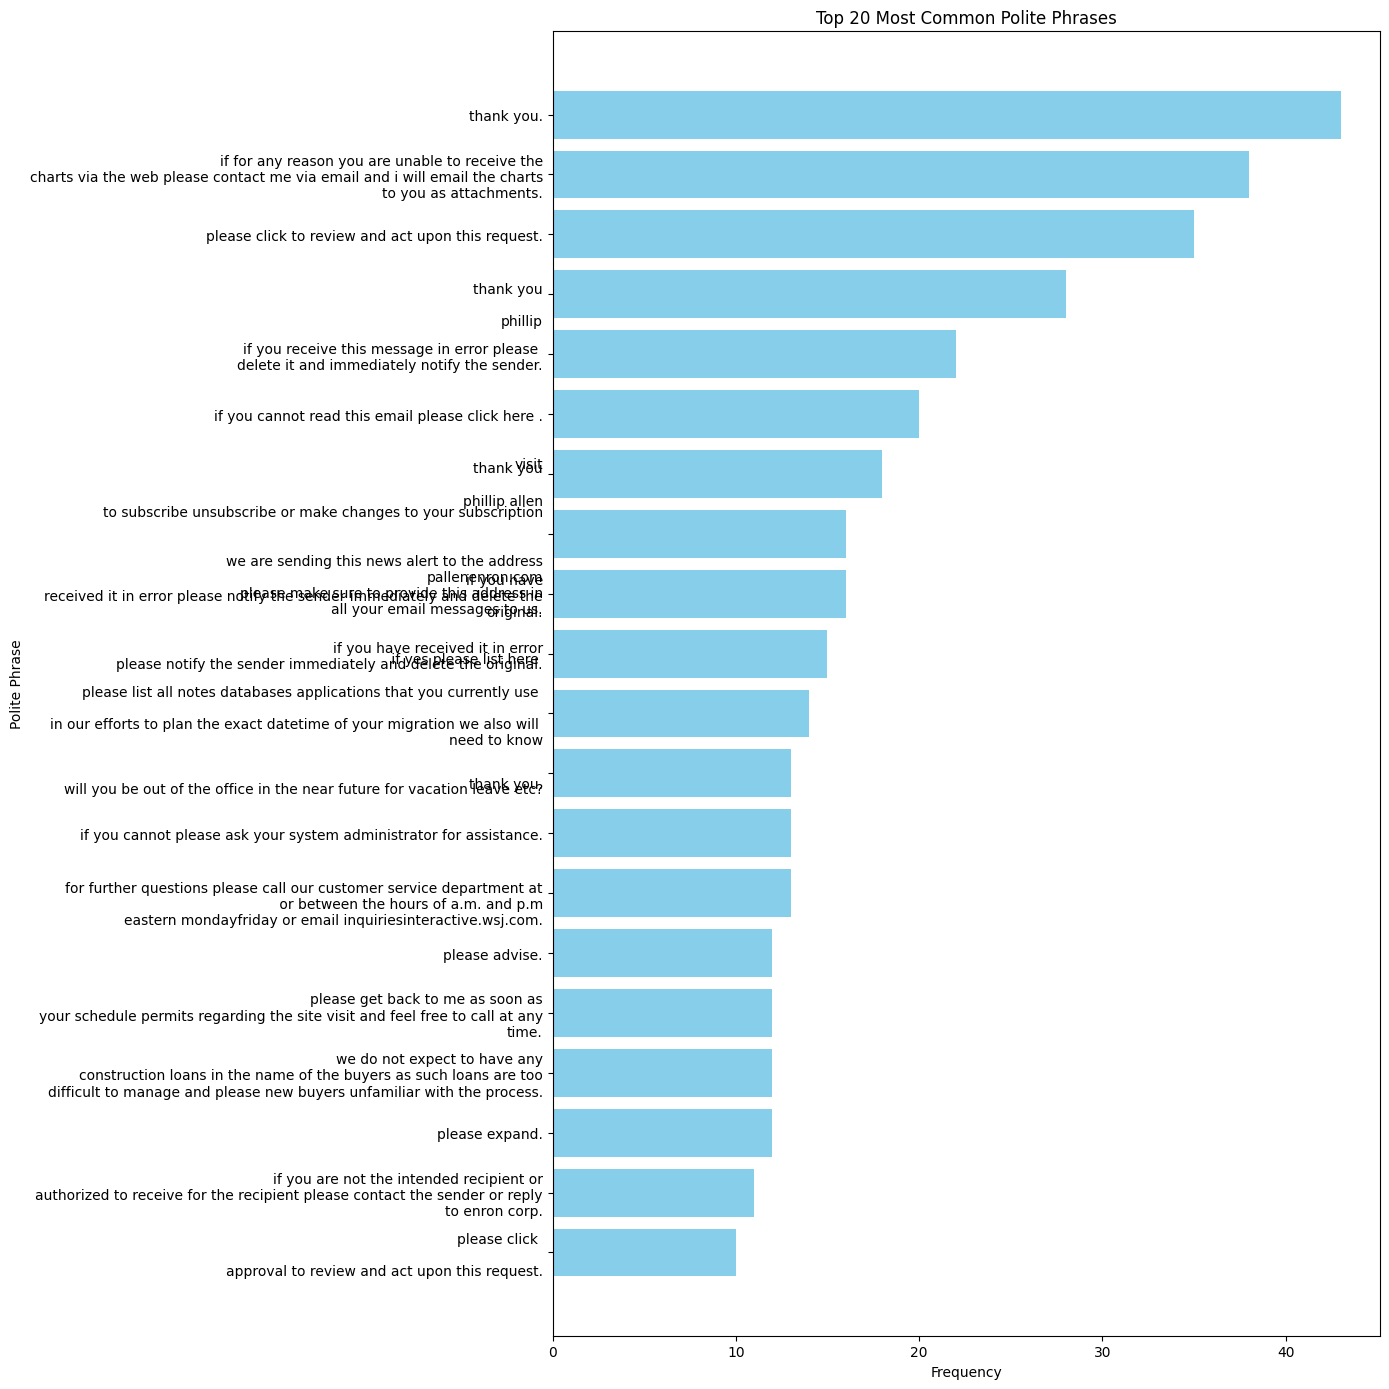

In [ ]:
# THE MOST POPULAR PLEASANTRIES

import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import itertools

all_phrases = list(itertools.chain.from_iterable(parsed_emails_pleasantries['polite_phrases']))

phrase_counts = Counter(all_phrases)

phrase_df = pd.DataFrame(phrase_counts.items(), columns=['Phrase', 'Frequency'])

phrase_df = phrase_df.sort_values(by='Frequency', ascending=False)

plt.figure(figsize=(14, 14))
plt.barh(phrase_df['Phrase'][:20], phrase_df['Frequency'][:20], color='skyblue', height=0.8)
plt.xlabel('Frequency')
plt.ylabel('Polite Phrase')
plt.title('Top 20 Most Common Polite Phrases')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

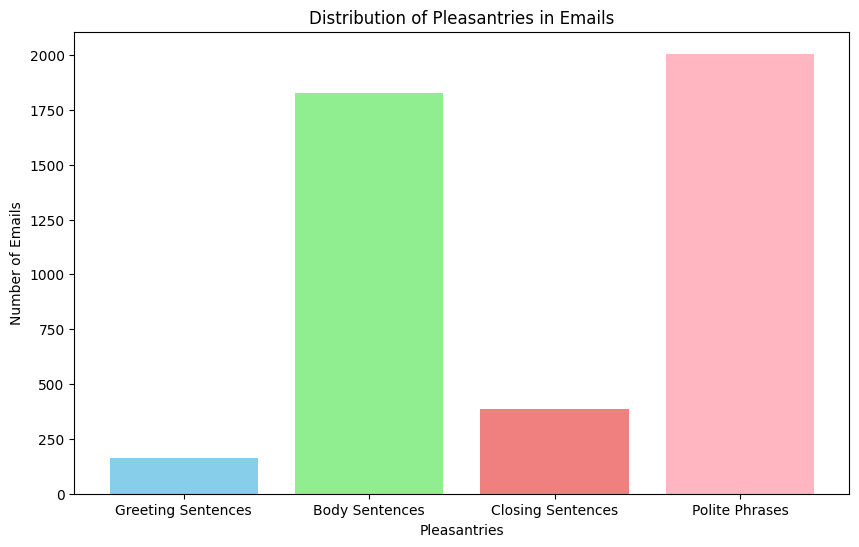

In [ ]:
# DISTRIBUTION OF PLEASANTRIES IN EMAILS

import pandas as pd
import matplotlib.pyplot as plt

counts = {
    'Greeting Sentences': parsed_emails_pleasantries['greeting_sentences'].apply(bool).sum(),
    'Body Sentences': parsed_emails_pleasantries['body_sentences'].apply(bool).sum(),
    'Closing Sentences': parsed_emails_pleasantries['closing_sentences'].apply(bool).sum(),
    'Polite Phrases': parsed_emails_pleasantries['polite_phrases'].apply(bool).sum()
}

plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values(), color=['skyblue', 'lightgreen', 'lightcoral', 'lightpink'])
plt.xlabel('Pleasantries')
plt.ylabel('Number of Emails')
plt.title('Distribution of Pleasantries in Emails')
plt.show()

# *Section III. Pleasantries Classificator.*

To prepare the data for training the classiier, I began by parsing each message into individual sentences. Specifically, I focused on  messages that contain pleasantries.

In [26]:
# PARSED BY SENTENCES

import pandas as pd
import re

non_empty_polite_phrases = pd.read_csv("/content/drive/My Drive/NLP/non_empty_polite_phrases.csv")

import nltk
nltk.download('punkt_tab')

from nltk.tokenize import sent_tokenize

def parse_sentences(text):
    return sent_tokenize(text)

non_empty_polite_phrases['parsed_by_sentences'] = non_empty_polite_phrases['clean_for_pleasantries'].apply(lambda x: parse_sentences(x) if isinstance(x, str) else [])
non_empty_polite_phrases[["clean_from_patterns","parsed_by_sentences"]].head(5)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,clean_from_patterns,parsed_by_sentences
0,Please cc the following distribution list with...,[please cc the following distribution list wit...
1,\nPlease plan to attend the below Meeting:\n\...,[please plan to attend the below meeting\n\n\n...
2,"Tim,\n\nmike grigsby is having problems with a...",[tim\n\nmike grigsby is having problems with a...
3,\n\nWestgate\n\nEnclosed are demographics on t...,[westgate\n\nenclosed are demographics on the ...
4,"\nThere will be a meeting on Tuesday, Oct. 10t...",[there will be a meeting on tuesday oct. th at...


To prepare the data for supervised learning, I implemented a sentence-level labeling mechanism to identidy whether each sentence in a message contains a pleasantry. The goal of this step is to generate binary labels (1 for pleasantries, 0 otherwise), which will later be used to train a classifier.

In [30]:
# LABEL THE SENTENCES

greetings = polite_greeting_clean['clean'].tolist()
body_phrases = polite_body_clean['clean'].tolist()
closings = polite_closing_clean['clean'].tolist()

def detect_pleasantries(sentences, greetings, body_phrases, closings):
    sentences = [s.lower() for s in sentences]
    greetings = [g.lower() for g in greetings]
    body_phrases = [b.lower() for b in body_phrases]
    closings = [c.lower() for c in closings]

    label_vector = []

    for idx, sentence in enumerate(sentences):
        sentence_label = 0

        if idx < 3 and any(phrase in sentence for phrase in greetings):
            sentence_label = 1

        elif idx >= len(sentences) - 5 and any(phrase in sentence for phrase in closings):
            sentence_label = 1

        elif any(phrase in sentence for phrase in body_phrases):
            sentence_label = 1

        label_vector.append(sentence_label)

    return label_vector

non_empty_polite_phrases['pleasantries_labels'] = non_empty_polite_phrases['parsed_by_sentences'].apply(
    lambda x: detect_pleasantries(x, greetings, body_phrases, closings)
)
non_empty_polite_phrases[['clean_for_pleasantries','parsed_by_sentences', 'pleasantries_labels']].head(5)

,clean_for_pleasantries,parsed_by_sentences,pleasantries_labels
0,please cc the following distribution list with...,[please cc the following distribution list wit...,[1]
1,please plan to attend the below meeting\n\n\n ...,[please plan to attend the below meeting\n\n\n...,"[1, 0]"
2,tim\n\nmike grigsby is having problems with ac...,[tim\n\nmike grigsby is having problems with a...,"[0, 1, 1]"
3,westgate\n\nenclosed are demographics on the w...,[westgate\n\nenclosed are demographics on the ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"
4,there will be a meeting on tuesday oct. th at ...,[there will be a meeting on tuesday oct. th at...,"[0, 1, 1, 1]"


To facilitate the training of a machine learning classifier, the dataset was transgormed into a flat structure in which each row represents a single sentence along with its corresponding label.

In [31]:
# PREPARE DATA AS UNIQUE DATASET

import pandas as pd

rows = []
for _, row in non_empty_polite_phrases.iterrows():
    sentences = row['parsed_by_sentences']
    labels = row['pleasantries_labels']
    for s, l in zip(sentences, labels):
        rows.append({'sentence': s, 'label': l})

pleasantries_sentences_flat = pd.DataFrame(rows)
pleasantries_sentences_flat.to_csv("/content/drive/My Drive/NLP/pleasantries_sentences_flat.csv", index=False)
pleasantries_sentences_flat.head(5)

,sentence,label
0,please cc the following distribution list with...,1
1,please plan to attend the below meeting\n\n\n ...,1
2,thanks\nrain\nx.,0
3,tim\n\nmike grigsby is having problems with ac...,0
4,can you please make sure he has an active pass...,1


To better understand the balance of the dataset, I examined the distribution of the binary class labels (pleasantry vs. non'pleasantry). The analysis revealed a noticeable class imbalance: approximately 86% of the sentences are labeled as non-pleasantry (label 0), while only 14% are labeled as pleasantry (label 1).

Class Distribution:
label
0    23706
1     3466
Name: count, dtype: int64


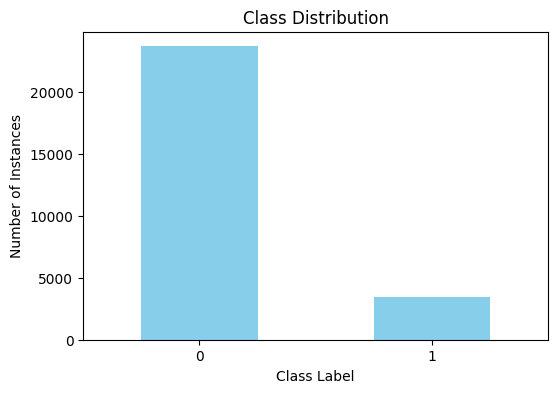


Class Proportions:
label
0    0.872442
1    0.127558
Name: count, dtype: float64


In [32]:
# CHECK CLASS DISTRIBUTION

import matplotlib.pyplot as plt

class_distribution = pleasantries_sentences_flat["label"].value_counts()

print("Class Distribution:")
print(class_distribution)

plt.figure(figsize=(6, 4))
class_distribution.plot(kind="bar", color="skyblue")
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Number of Instances")
plt.xticks(rotation=0)
plt.show()

class_proportions = class_distribution / len(pleasantries_sentences_flat)
print("\nClass Proportions:")
print(class_proportions)

To address the class imbalance observed in the sentence-level dataset, I applied a downsampling technique to the majority class (non-pleasantry label 0). This ensures that both classes are equally represnted during model training, helping to prevent the classifier from becoming biased toward the dominant class.

In [33]:
# DOWNSAMPLING THE MAJORITY CLASS

from sklearn.utils import resample

pleasantries_sentences_minority = pleasantries_sentences_flat[pleasantries_sentences_flat["label"] == 1]
pleasantries_sentences_majority = pleasantries_sentences_flat[pleasantries_sentences_flat["label"] == 0]

pleasantries_sentences_majority_downsampled = resample(pleasantries_sentences_majority,
                                   replace=False,
                                   n_samples=len(pleasantries_sentences_minority),
                                   random_state=42)

pleasantries_sentences_balanced = pd.concat([pleasantries_sentences_minority,pleasantries_sentences_majority_downsampled])

pleasantries_sentences_balanced = pleasantries_sentences_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
pleasantries_sentences_balanced.head(5)

,sentence,label
0,these professional expenses will be incurred o...,0
1,thank you and if you have any questions feel f...,1
2,thank you \n\nphillip allen,1
3,i think consensus \nopinion is that anything u...,0
4,please email me\nthe correct one when you get ...,1


Class Distribution:
label
0    3466
1    3466
Name: count, dtype: int64


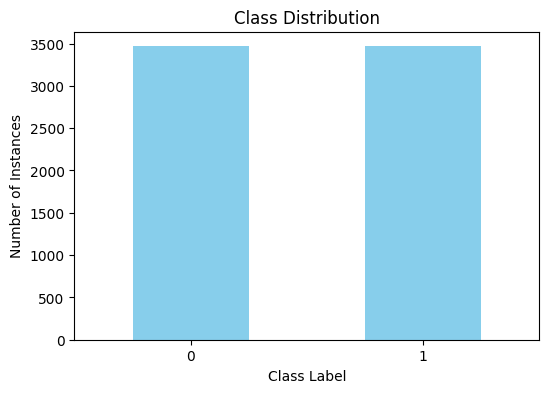


Class Proportions:
label
0    0.5
1    0.5
Name: count, dtype: float64


In [34]:
# CHECK CLASS DISTRIBUTION AFTER DOWNSAMPLING

import matplotlib.pyplot as plt

class_distribution = pleasantries_sentences_balanced["label"].value_counts()

print("Class Distribution:")
print(class_distribution)

plt.figure(figsize=(6, 4))
class_distribution.plot(kind="bar", color="skyblue")
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Number of Instances")
plt.xticks(rotation=0)
plt.show()

class_proportions = class_distribution / len(pleasantries_sentences_balanced)
print("\nClass Proportions:")
print(class_proportions)

For training the model, I need to label emails that contain polite phrases. To archive this, I add a new column `polite_label`, which assigns labels to emails based on the presence of polite phrases.

Data labeling is essential for supervised learning, as it provides context so that a machine learning model can learn from it.

In [35]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

np.random.seed(500)

The Corpus will be split into two data sets: Training and Test. The training data set will be used to fit the model and the predictions will be performed on the test data set. This can be done through the `train_test_split` from the `sklearn` library. The Training Data will have 70% of the corpus and Test data will have the remaining 30% as we have set the parameter `test_size`=0.3.

In [36]:
# SPLIT INTO TRAINING (70%) AND TESTING (30%) DATASET

X = pleasantries_sentences_balanced["sentence"].astype(str)
Y = pleasantries_sentences_balanced["label"]

Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(X, Y, test_size=0.3, random_state=42)
Train_X.head(5)

,sentence
3123,mark\n\n attached is a spreadsheet that lists ...
47,please do not reply to this email.
5724,ina\ncan you set up a minute mtg with me and a...
1350,if you have questions or concerns using the ow...
5689,i know \nthere are existing and potential link...


In [ ]:
# LABEL CLASS DISTRIBUTION

print("Train_Y class distribution:", Train_Y.value_counts())
print("Test_Y class distribution:", Test_Y.value_counts())

Train_Y class distribution: label
1    2457
0    2395
Name: count, dtype: int64
Test_Y class distribution: label
0    1071
1    1009
Name: count, dtype: int64


Text vectorization is the process of converting text documents into numerical feature vectors. One of the most popular methods is TF-IDF (Term Frequency-Inverse Document Frequency), which assigns scores to words based on their frequency in a document and across the corpus.

* Term Frequency: Measures how often a word appears in a document.
* Inverse Document Frequency: Downscales words that are common across documents.

TF-IDF highlights words that are frequent in a document but not across the corpus, making them more informative.

To apply this, we first fit the TF-IDF model on the entire corpus, creating a vocabulary of up to 5000 unique words (set by `max_features`=5000). Then, we transform `Train_X` and `Test_X` into vectorized forms (`Train_X_Tfidf` and `Test_X_Tfidf`), where each word is represented by a unique integer and its importance score.

In [37]:
# CONVERT EMAIL'S TEXT TO NUMERICAL FEATURES USING TF-IDF

Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(Train_X)

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)
print(Train_X_Tfidf)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 65452 stored elements and shape (4852, 5000)>
  Coords	Values
  (0, 175)	0.09587621412714524
  (0, 292)	0.2082304206094786
  (0, 377)	0.25670425955780035
  (0, 941)	0.22010727903686217
  (0, 1205)	0.26213720541824154
  (0, 1460)	0.10561142969431508
  (0, 2080)	0.12635388898270078
  (0, 2186)	0.266209266685473
  (0, 2458)	0.3205259960824528
  (0, 2605)	0.24374744209175706
  (0, 2766)	0.3413097826026052
  (0, 3132)	0.10670094181842467
  (0, 4263)	0.2684090811276985
  (0, 4266)	0.3296049610327071
  (0, 4325)	0.3205259960824528
  (0, 4326)	0.26024446153679387
  (0, 4535)	0.13919898887294774
  (0, 4538)	0.07648973059646992
  (1, 1081)	0.457733910820618
  (1, 1190)	0.3830985023536404
  (1, 3064)	0.4038999698080128
  (1, 3554)	0.21352613042075494
  (1, 3925)	0.5394572377609943
  (1, 4558)	0.3134943704952535
  (1, 4599)	0.21376103174093314
  :	:
  (4846, 4531)	0.43116500974659416
  (4846, 4969)	0.2525743287658319
  (4846, 4974)	0.35

There is the vocabulary that it has learned from the corpus.

In [ ]:
print(Tfidf_vect.vocabulary_)

{'mark': np.int64(2605), 'attached': np.int64(292), 'is': np.int64(2080), 'spreadsheet': np.int64(4326), 'that': np.int64(4535), 'lists': np.int64(2458), 'the': np.int64(4538), 'end': np.int64(1205), 'of': np.int64(3132), 'day': np.int64(941), 'midmarkets': np.int64(2766), 'for': np.int64(1460), 'socal': np.int64(4263), 'basis': np.int64(377), 'and': np.int64(175), 'socalsan': np.int64(4266), 'juan': np.int64(2186), 'spreads': np.int64(4325), 'please': np.int64(3554), 'do': np.int64(1081), 'not': np.int64(3064), 'reply': np.int64(3925), 'to': np.int64(4599), 'this': np.int64(4558), 'email': np.int64(1190), 'ina': np.int64(1869), 'can': np.int64(554), 'you': np.int64(4969), 'set': np.int64(4161), 'up': np.int64(4737), 'minute': np.int64(2803), 'mtg': np.int64(2908), 'with': np.int64(4916), 'me': np.int64(2685), 'all': np.int64(137), 'assistants': np.int64(275), 'runners': np.int64(4050), 'in': np.int64(1868), 'regards': np.int64(3870), 'what': np.int64(4879), 'we': np.int64(4851), 'disc

Multinomial Naive Bayes is a probabilistic classifier based on Bayes’ theorem with strong (naive) independence assumptions between features. It is specifically designed for classification tasks with discrete features, such as word counts in text data.

Key Components of Multinomial Naive Bayes
* Bayes’ Theorem: MNB utilizes Bayes’ theorem to calculate the posterior
probability of a class given a set of features. Bayes’ theorem states that the posterior probability is proportional to the product of the likelihood and the prior probability, divided by the evidence.
* Conditional Independence: The “naive” assumption in MNB is that the features are conditionally independent given the class label. This means that the presence or absence of a particular feature is assumed to be independent of the presence or absence of other features, given the class.
* Multinomial Distribution: MNB models the likelihood of observing each feature in a document as a multinomial distribution. It computes the probability of a document belonging to a particular class based on the frequencies of words (or other features) in the document.

In [ ]:
# TRAIN NAIVE BAYES CLASSIFIER

Naive = naive_bayes.MultinomialNB()
Naive.fit(Train_X_Tfidf, Train_Y)

MultinomialNB()

The accuracy score of 81.77% indicates that your Naive Bayes classifier has correctly classified 81.77% of the test samples.

In [ ]:
# PREDICTION AND EVALUATION FOR NAIVE BAYES CLASSIFIER

predictions_NB = Naive.predict(Test_X_Tfidf)

accuracy = accuracy_score(Test_Y, predictions_NB)
print("Naive Bayes Accuracy Score ->", accuracy * 100)

Naive Bayes Accuracy Score -> 81.77884615384615


The confusion matrix shows the count of correct and incorrect predictions, broken down by class. It helps you visualize the performance across all classes.

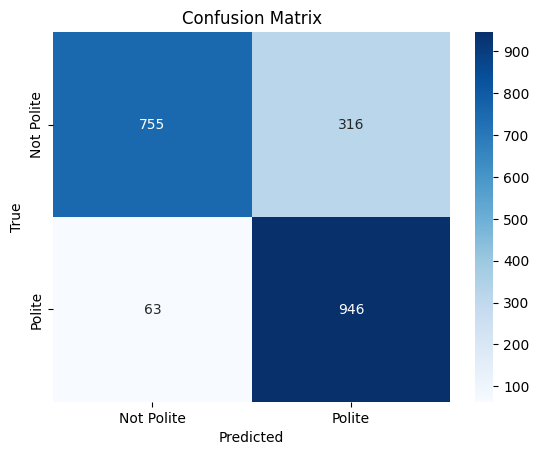

In [ ]:
# PLOT OF THE CONFUSION MATRIX FOR NAIVE BAYES CLASSIFIER

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_nb = confusion_matrix(Test_Y, predictions_NB)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Polite', 'Polite'], yticklabels=['Not Polite', 'Polite'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The model performs well overall with an accuracy of 86%.
The model is better at detecting non-polite emails (class 0) with high recall (95%) but struggles a bit more with polite emails (class 1), as indicated by the lower recall (75%).
The F1-score reflects the balanced performance of the classifier, with good overall results.

The F1-score is the harmonic mean of precision and recall. It balances the trade-off between precision and recall.

In [ ]:
# CLASSIFICATION REPORT

from sklearn.metrics import classification_report
print(classification_report(Test_Y, predictions_NB))

              precision    recall  f1-score   support

           0       0.92      0.70      0.80      1071
           1       0.75      0.94      0.83      1009

    accuracy                           0.82      2080
   macro avg       0.84      0.82      0.82      2080
weighted avg       0.84      0.82      0.82      2080



The ROC (Receiver Operating Characteristics) curve will give an idea of how well the classifier is distinguishing between classes, while the AUC (Area Under the Curve) provides a summary of the model's performance.

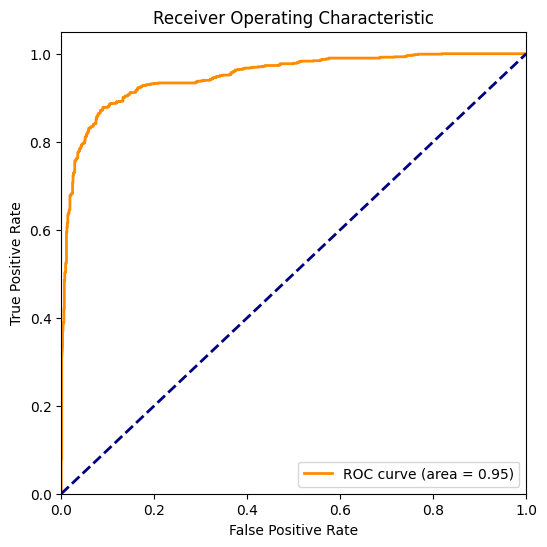

In [ ]:
# ROC CURVE

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Test_Y, Naive.predict_proba(Test_X_Tfidf)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Linear SVM is a type of SVM that uses a linear kernel function, making it suitable for datasets that are linearly separable. It aims to find a straight line (in two dimensions) that best divides the data into different classes. Linear SVM is computationally efficient and works well with large datasets where the number of features is greater than the number of samples.

In [38]:
# TRAIN SVM CLASSIFIER

SVM = svm.SVC(C=1.0, kernel="linear", degree=3, gamma="auto")
SVM.fit(Train_X_Tfidf, Train_Y)

SVC(gamma='auto', kernel='linear')

In [39]:
# PREDICTION AND EVALUATION FOR SVM CLASSIFIER

predictions_SVM = SVM.predict(Test_X_Tfidf)
accuracy = accuracy_score(Test_Y, predictions_SVM)
print("SVM Accuracy Score ->", accuracy * 100)

SVM Accuracy Score -> 98.02884615384615


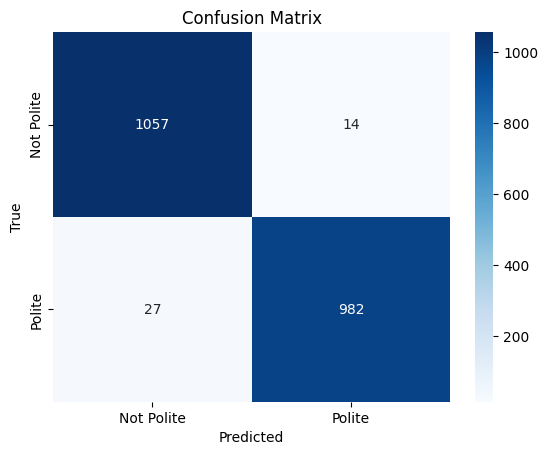

In [ ]:
# PLOT OF THE CONFUSION MATRIX FOR SVM CLASSIFIER

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_svm = confusion_matrix(Test_Y, predictions_SVM)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Polite', 'Polite'], yticklabels=['Not Polite', 'Polite'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The precision, recall, and F1-scores are very high for both classes, and the overall accuracy is also 97%, which indicates that your model is correctly classifying emails with very few errors.
Both polite and non-polite emails are being handled well by the classifier, with only minor differences between precision, recall, and F1-score for each class, which is excellent for a binary classification task.

In [ ]:
# CLASSIFICATION REPORT

from sklearn.metrics import classification_report
print(classification_report(Test_Y, predictions_SVM))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1071
           1       0.99      0.97      0.98      1009

    accuracy                           0.98      2080
   macro avg       0.98      0.98      0.98      2080
weighted avg       0.98      0.98      0.98      2080



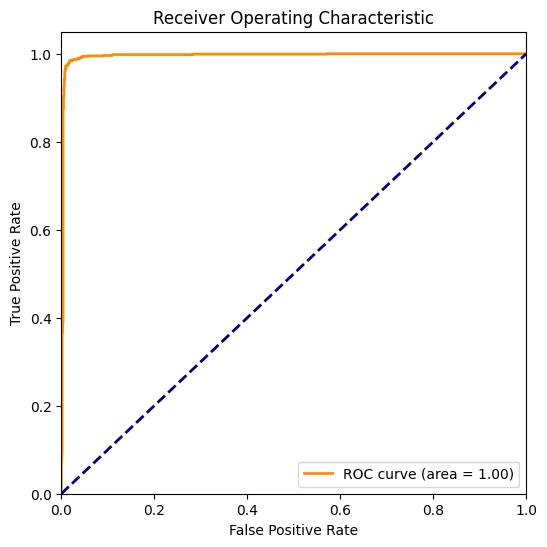

In [41]:
# ROC CURVE

from sklearn.svm import SVC

SVM = SVC(probability=True, kernel='linear')
SVM.fit(Train_X_Tfidf, Train_Y)

from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(Test_Y, SVM.predict_proba(Test_X_Tfidf)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

To plot the decision boundary of a Naive Bayes classifier, we can use Principal Component Analysis (PCA) for dimensionality reduction (if the data has more than 2 features). This will reduce the feature space to 2D so that we can plot the decision boundaries.

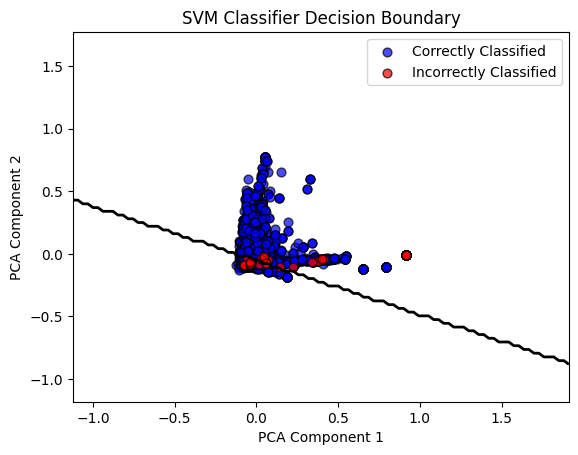

In [ ]:
# SVM CLASSIFIER DECISION BOUNDARY

import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

pca = PCA(n_components=2)
X_reduced = pca.fit_transform(Train_X_Tfidf.toarray())

xx, yy = np.meshgrid(np.linspace(X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1, 100),
                     np.linspace(X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1, 100))

Z = SVM.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = Z.reshape(xx.shape)

plt.contour(xx, yy, Z, levels=[0], alpha=1.0, colors='k', linewidths=2)

predictions_train = SVM.predict(Train_X_Tfidf)

correct_classifications = Train_Y == predictions_train
incorrect_classifications = ~correct_classifications

plt.scatter(X_reduced[correct_classifications, 0], X_reduced[correct_classifications, 1],
            c='blue', edgecolors='k', marker='o', s=40, alpha=0.7, label='Correctly Classified')

plt.scatter(X_reduced[incorrect_classifications, 0], X_reduced[incorrect_classifications, 1],
            c='red', edgecolors='k', marker='o', s=40, alpha=0.7, label='Incorrectly Classified')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('SVM Classifier Decision Boundary')
plt.legend(loc='best')
plt.show()

# *Section XI. Extract Signatures.*

In [ ]:
import pandas as pd

parsed_emails_pleasantries_signatures = pd.read_csv("/content/drive/My Drive/NLP/parsed_emails_pleasantries.csv")
parsed_emails_pleasantries_signatures.head(5)

,file,message,body,date,from,to,subject,clean_from_patterns,clean_for_pleasantries,greeting_sentences,body_sentences,closing_sentences,polite_phrases
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,Mime-Version: 1.0,Here is our forecast,here is our forecast,[],[],[],[]
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,Traveling to have a business meeting takes the...,traveling to have a business meeting takes the...,[],[],[],[]
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!,test successful. way to go!!!,[],[],[],[]
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"Randy,\n\n Can you send me a schedule of the s...",randy\n\n can you send me a schedule of the sa...,[],[],[],[]
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,Let's shoot for Tuesday at 11:45.,lets shoot for tuesday at .,[],[],[],[]


I remove double spaces from the `clean_from_patterns` column to simplify the identification of the email signature.

In [ ]:
# REMOVE DOUBLE SPACES FROM THE BODY COLUMN

import re

#parsed_emails_pleasantries_signatures = parsed_emails_pleasantries.copy()

def remove_double_spaces(text):
  if isinstance(text, str):
    text = text.lower()
    text = re.sub(r" {2,}", " ", text)
    return text
  else:
    return text

parsed_emails_pleasantries_signatures["clean_from_patterns"] = parsed_emails_pleasantries_signatures["clean_from_patterns"].apply(remove_double_spaces)
parsed_emails_pleasantries_signatures.head(5)

,file,message,body,date,from,to,subject,clean_from_patterns,clean_for_pleasantries,greeting_sentences,body_sentences,closing_sentences,polite_phrases
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,Mime-Version: 1.0,here is our forecast,here is our forecast,[],[],[],[]
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,traveling to have a business meeting takes the...,traveling to have a business meeting takes the...,[],[],[],[]
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!,test successful. way to go!!!,[],[],[],[]
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"randy,\n\n can you send me a schedule of the s...",randy\n\n can you send me a schedule of the sa...,[],[],[],[]
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,let's shoot for tuesday at 11:45.,lets shoot for tuesday at .,[],[],[],[]


For extracting the signatures I use the following features:
1. the common signature separators like `---` or a closing pleasantry in the last few lines of the email.
2. the average length of the last few lines below a certain threshold (50 characters per line). Shorter lines are more likely to be part of a signature. It helps to identify short signature lines.
3. the common signature phrases like `sent from my iPhone`, `Confidentiality Notice`, etc. .
4. the presence of contact information, such as phone numbers, email addresses, and URLs, using regular expressions.
5. the presence of the job title keywords like `engineer`, `manager`, etc.
6. the presence of one or two words, which is common for names. This helps catch signatures that are just the sender's name.
7. the name extracted from the sender's email address appearing in the last line of the email body. If so, it's a strong indicator of a signature.

`has_signature` function combines the feature functions to determine if an email likely has a signature. It calculates a score based on the presence of different signature indicators.

In [ ]:
# EXTRACT THE SIGNATURES

import re
import pandas as pd

# --- Feature Functions ---

closing_pleasantries = r"^\b(regards|sincerely|best regards|thank you|thanks)\b[,.\-!]*$"
signature_phrases = ["sent from my iphone", "sent from my android", "confidentiality notice", "visit our website", "follow us on"]

def has_signature_separator(text):
    """Checks for common signature separators."""
    lines = text.splitlines()
    for line in lines[-6:]:
        line = line.strip()
        if line == '---':
            return True
        if re.match(closing_pleasantries, line.lower()):
            return True
        if re.match(r"^[-_]{3,}$", line):
            return True
        if line.startswith(">"):  # Quoted text
            continue
    return False

def signature_length_analysis(text, threshold=5):
    """Checks if the last few lines (potential signature) are shorter than the threshold."""
    lines = text.splitlines()
    if len(lines) <= threshold:
        return False
    last_lines = lines[-threshold:]
    total_length = sum(len(line) for line in last_lines)
    return total_length / threshold < 50

def has_common_signature_phrases(text):
    """Looks for common signature phrases."""
    lines = text.splitlines()
    signature_phrases = ["sent from my iphone", "sent from my android", "confidentiality notice", "visit our website", "follow us on", "regards", "sincerely", "best regards", "thank you", "thanks"]
    return any(phrase in line.lower() for line in lines[-5:] for phrase in signature_phrases)

def has_contact_info(text):
    """Checks for the presence of contact information (phone, email, URL)."""
    phone_regex = re.compile(r'(\+\d{1,2}\s?)?(\(\d{3}\)|\d{3})[\s-]?\d{3}[\s-]?\d{4}')
    email_regex = re.compile(r'[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}')
    url_regex = re.compile(r'https?://\S+|www\.\S+')

    return phone_regex.search(text) is not None or \
           email_regex.search(text) is not None or \
           url_regex.search(text) is not None

def has_job_title(text):
    """Checks if any lines contain common Job titles."""
    lines = text.splitlines()
    job_title_keywords = ["engineer", "manager", "director", "analyst", "president", "ceo", "cfo"]
    return any(keyword in line.lower() for line in lines[-5:] for keyword in job_title_keywords)

def has_single_word_signature(text):
    """Checks if the last non-empty line contains only one or two words, which is common for names."""
    lines = [line.strip() for line in text.splitlines() if line.strip()]
    if not lines:
        return False
    last_line = lines[-1]

    return bool(re.match(r"^[A-Za-z-]+(\s[A-Za-z-]+)?$", last_line))

def extract_names(email):

    """
    Extracts the name of sender
    """

    if not isinstance(email, str):
        return []
    username = email.split("@")[0]
    names = re.split(r'[._]', username)
    return [name.lower() for name in names]


def check_names_in_last_row(email_body, sender_email):
    """
    Checks if the sender's name appears in the last row of 'clean'.
    """
    names = extract_names(sender_email)
    lines = email_body.split("\n")
    last_line = lines[-1].lower().strip() if lines else ""
    return any(re.search(rf"\b{name}\b", last_line) for name in names)

def count_sentences(text):
    """
    Counts the number of sentences in the email body.
    """
    return len(re.findall(r'[.!?](?:\s|$)', text))

# --- Combined Signature Detection Function ---

def has_signature(email_body, sender_email):
    """
    Combines multiple features to determine if an email likely has a signature.
    """
    if not isinstance(email_body, str):
        return False

    if count_sentences(email_body) < 2:
      return False

    score = 0

    if has_signature_separator(email_body):
        score += 0.3
    if signature_length_analysis(email_body):
        score += 0.2
    if has_common_signature_phrases(email_body):
        score += 0.5
    if has_contact_info(email_body):
        score += 0.2
    if has_job_title(email_body):
        score += 0.2
    if check_names_in_last_row(email_body, sender_email):
        score += 0.5
    if has_single_word_signature(email_body):
        score += 0.5

    return score > 0.4

def extract_signature(email_body, sender_email):
    """
    Extracts the signature from an email body.
    """
    if not isinstance(email_body, str) or not has_signature(email_body, sender_email):
      return ""

    lines = email_body.strip().splitlines()
    lines = lines[-10:]

    signature_start = None
    for i in range(len(lines) - 1, -1, -1):
      line = lines[i].strip()

      if has_signature_separator(line) or has_common_signature_phrases(line):
          signature_start = i
      elif has_single_word_signature(line) or check_names_in_last_row(line, sender_email):
        if signature_start is None:
          signature_start = i

    if signature_start is not None:
      extracted_signature = '\n'.join(lines[signature_start:]).strip()

      if not re.search(r"[a-zA-Z]", extracted_signature):
        return ""

      return extracted_signature

    return ""

parsed_emails_pleasantries_signatures["signature"] = parsed_emails_pleasantries_signatures.apply(
    lambda row: extract_signature(row["clean_from_patterns"], row["from"]), axis=1
)
parsed_emails_pleasantries_signatures.to_csv("/content/drive/My Drive/NLP/parsed_emails_pleasantries_signatures.csv", index=False)
parsed_emails_pleasantries_signatures.head(5)

,file,message,body,date,from,to,subject,clean_from_patterns,clean_for_pleasantries,greeting_sentences,body_sentences,closing_sentences,polite_phrases,signature
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,Mime-Version: 1.0,here is our forecast,here is our forecast,[],[],[],[],
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,traveling to have a business meeting takes the...,traveling to have a business meeting takes the...,[],[],[],[],
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!,test successful. way to go!!!,[],[],[],[],
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"randy,\n\n can you send me a schedule of the s...",randy\n\n can you send me a schedule of the sa...,[],[],[],[],phillip
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,let's shoot for tuesday at 11:45.,lets shoot for tuesday at .,[],[],[],[],


In [ ]:
# FILTER NON-EMPTY ROWS FOR signature

non_empty_signature = parsed_emails_pleasantries_signatures[parsed_emails_pleasantries_signatures['signature'].apply(lambda x: len(x) > 0)]
non_empty_signature.head(5)

,file,message,body,date,from,to,subject,clean_from_patterns,clean_for_pleasantries,greeting_sentences,body_sentences,closing_sentences,polite_phrases,signature
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"randy,\n\n can you send me a schedule of the s...",randy\n\n can you send me a schedule of the sa...,[],[],[],[],phillip
10,allen-p/_sent_mail/103.,Message-ID: <33076797.1075855687515.JavaMail.e...,"Mr. Buckner,\n\n For delivered gas behind San ...","Mon, 16 Oct 2000 06:42:00 -0700 (PDT)",phillip.allen@enron.com,buck.buckner@honeywell.com,Re: FW: fixed forward or other Collar floor ga...,"mr. buckner,\n\n for delivered gas behind san ...",mr. buckner\n\n for delivered gas behind san d...,[],[],[],[],phillip allen
11,allen-p/_sent_mail/104.,Message-ID: <25459584.1075855687536.JavaMail.e...,"Lucy,\n\n Here are the rentrolls:\n\n\n\n Open...","Fri, 13 Oct 2000 06:45:00 -0700 (PDT)",phillip.allen@enron.com,stagecoachmama@hotmail.com,Mime-Version: 1.0,"lucy,\n\n here are the rentrolls:\n\n\n\n open...",lucy\n\n here are the rentrolls\n\n\n\n open t...,[],[],[],[],phillip
14,allen-p/_sent_mail/107.,Message-ID: <2465689.1075855687605.JavaMail.ev...,"Dave, \n\n Here are the names of the west desk...","Thu, 5 Oct 2000 06:26:00 -0700 (PDT)",phillip.allen@enron.com,david.delainey@enron.com,Mime-Version: 1.0,"dave, \n\n here are the names of the west desk...",dave \n\n here are the names of the west desk ...,[],[],[],[],phillip
17,allen-p/_sent_mail/11.,Message-ID: <7391389.1075855378477.JavaMail.ev...,"Tim,\n\nmike grigsby is having problems with a...","Fri, 4 May 2001 11:26:00 -0700 (PDT)",phillip.allen@enron.com,tim.heizenrader@enron.com,Mime-Version: 1.0,"tim,\n\nmike grigsby is having problems with a...",tim\n\nmike grigsby is having problems with ac...,[],['can you please make sure he has an active pa...,['\n\nthank you\n\nphillip'],"['\n\nthank you\n\nphillip', 'can you please m...","thank you,\n\nphillip"


# *Section X. Signature Classifier*.





The code above extracts the last 6 lines from each email body in the `non_empty_signature` dataset. The function extract_last_lines takes a text string and splits it into individual lines using the `splitlines` method.
This extraction is particularly useful because signatures in emails are often located towards the end of the message, typically in the last few lines. By focusing on the last 6 lines, we can efficiently capture the signature and use this data for further analysis and model training

In [ ]:
# EXTRACT THE LAST 6 LINES

def extract_last_lines(text, num_lines=6):
    lines = text.strip().splitlines()
    return lines[-num_lines:] if len(lines) > num_lines else lines

non_empty_signature["body_lines"] = non_empty_signature["clean_from_patterns"].apply(extract_last_lines)
non_empty_signature.head()

<ipython-input-28-14b5d45334d1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_empty_signature["body_lines"] = non_empty_signature["clean_from_patterns"].apply(extract_last_lines)


,file,message,body,date,from,to,subject,clean_from_patterns,clean_for_pleasantries,greeting_sentences,body_sentences,closing_sentences,polite_phrases,signature,body_lines
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"randy,\n\n can you send me a schedule of the s...",randy\n\n can you send me a schedule of the sa...,[],[],[],[],phillip,"[, can you send me a schedule of the salary a..."
10,allen-p/_sent_mail/103.,Message-ID: <33076797.1075855687515.JavaMail.e...,"Mr. Buckner,\n\n For delivered gas behind San ...","Mon, 16 Oct 2000 06:42:00 -0700 (PDT)",phillip.allen@enron.com,buck.buckner@honeywell.com,Re: FW: fixed forward or other Collar floor ga...,"mr. buckner,\n\n for delivered gas behind san ...",mr. buckner\n\n for delivered gas behind san d...,[],[],[],[],phillip allen,"[, for delivered gas behind san diego, enron ..."
11,allen-p/_sent_mail/104.,Message-ID: <25459584.1075855687536.JavaMail.e...,"Lucy,\n\n Here are the rentrolls:\n\n\n\n Open...","Fri, 13 Oct 2000 06:45:00 -0700 (PDT)",phillip.allen@enron.com,stagecoachmama@hotmail.com,Mime-Version: 1.0,"lucy,\n\n here are the rentrolls:\n\n\n\n open...",lucy\n\n here are the rentrolls\n\n\n\n open t...,[],[],[],[],phillip,[ 2. click on the drop down triangle under sav...
14,allen-p/_sent_mail/107.,Message-ID: <2465689.1075855687605.JavaMail.ev...,"Dave, \n\n Here are the names of the west desk...","Thu, 5 Oct 2000 06:26:00 -0700 (PDT)",phillip.allen@enron.com,david.delainey@enron.com,Mime-Version: 1.0,"dave, \n\n here are the names of the west desk...",dave \n\n here are the names of the west desk ...,[],[],[],[],phillip,"[, , , , , phillip]"
17,allen-p/_sent_mail/11.,Message-ID: <7391389.1075855378477.JavaMail.ev...,"Tim,\n\nmike grigsby is having problems with a...","Fri, 4 May 2001 11:26:00 -0700 (PDT)",phillip.allen@enron.com,tim.heizenrader@enron.com,Mime-Version: 1.0,"tim,\n\nmike grigsby is having problems with a...",tim\n\nmike grigsby is having problems with ac...,[],['can you please make sure he has an active pa...,['\n\nthank you\n\nphillip'],"['\n\nthank you\n\nphillip', 'can you please m...","thank you,\n\nphillip","[, mike grigsby is having problems with access..."


The code above labels the rows in the emails in the non_empty_signature dataset by identifying the signature section in each email body. The function `generate_signature_label` processes the email body line by line, checking for specific markers that indicate the start and end of the signature.

In [ ]:
# LABEL THE ROWS IN THE EMAILS

import pandas as pd

def generate_signature_label(email_body, sender_email):
    """
    Extracts the signature from an email body.
    """
    if not isinstance(email_body, str):
      return ""

    lines = email_body.strip().splitlines()

    if not has_signature(email_body, sender_email):
        return [0] * len(lines)

    lines = lines[-10:]

    signature_start = None
    for i in range(len(lines) - 1, -1, -1):
      line = lines[i].strip()

      if has_signature_separator(line) or has_common_signature_phrases(line):
          signature_start = i
      elif has_single_word_signature(line) or check_names_in_last_row(line, sender_email):
        if signature_start is None:
          signature_start = i

    if signature_start is not None:
      return [0] * signature_start + [1] * (len(lines) - signature_start)

    elif signature_start is None:
      return [0] * len(lines)


def add_signature_labels_to_dataframe(df):
    """Adds signature labels to the dataframe for each email."""
    df['signature_label'] = df.apply(
        lambda row: generate_signature_label(row["clean_from_patterns"], row["from"]), axis=1
    )
    return df

def trim_labels(labels, num_labels=6):
    """Keeps only the last 10 labels or all if fewer than 10."""
    return labels[-num_labels:] if len(labels) > num_labels else labels

non_empty_signature = add_signature_labels_to_dataframe(non_empty_signature)
non_empty_signature["signature_label"] = non_empty_signature["signature_label"].apply(trim_labels)

non_empty_signature = non_empty_signature.reset_index(drop=True)

non_empty_signature.to_csv("/content/drive/My Drive/NLP/parsed_emails_pleasantries_signatures_with_labels.csv", index=False)
non_empty_signature.head(5)

<ipython-input-29-d8729b523b35>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['signature_label'] = df.apply(
<ipython-input-29-d8729b523b35>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_empty_signature["signature_label"] = non_empty_signature["signature_label"].apply(trim_labels)


,file,message,body,date,from,to,subject,clean_from_patterns,clean_for_pleasantries,greeting_sentences,body_sentences,closing_sentences,polite_phrases,signature,body_lines,signature_label
0,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"randy,\n\n can you send me a schedule of the s...",randy\n\n can you send me a schedule of the sa...,[],[],[],[],phillip,"[, can you send me a schedule of the salary a...","[0, 0, 0, 0, 0, 1]"
1,allen-p/_sent_mail/103.,Message-ID: <33076797.1075855687515.JavaMail.e...,"Mr. Buckner,\n\n For delivered gas behind San ...","Mon, 16 Oct 2000 06:42:00 -0700 (PDT)",phillip.allen@enron.com,buck.buckner@honeywell.com,Re: FW: fixed forward or other Collar floor ga...,"mr. buckner,\n\n for delivered gas behind san ...",mr. buckner\n\n for delivered gas behind san d...,[],[],[],[],phillip allen,"[, for delivered gas behind san diego, enron ...","[0, 0, 0, 0, 0, 1]"
2,allen-p/_sent_mail/104.,Message-ID: <25459584.1075855687536.JavaMail.e...,"Lucy,\n\n Here are the rentrolls:\n\n\n\n Open...","Fri, 13 Oct 2000 06:45:00 -0700 (PDT)",phillip.allen@enron.com,stagecoachmama@hotmail.com,Mime-Version: 1.0,"lucy,\n\n here are the rentrolls:\n\n\n\n open...",lucy\n\n here are the rentrolls\n\n\n\n open t...,[],[],[],[],phillip,[ 2. click on the drop down triangle under sav...,"[0, 0, 0, 0, 0, 1]"
3,allen-p/_sent_mail/107.,Message-ID: <2465689.1075855687605.JavaMail.ev...,"Dave, \n\n Here are the names of the west desk...","Thu, 5 Oct 2000 06:26:00 -0700 (PDT)",phillip.allen@enron.com,david.delainey@enron.com,Mime-Version: 1.0,"dave, \n\n here are the names of the west desk...",dave \n\n here are the names of the west desk ...,[],[],[],[],phillip,"[, , , , , phillip]","[0, 0, 0, 0, 0, 1]"
4,allen-p/_sent_mail/11.,Message-ID: <7391389.1075855378477.JavaMail.ev...,"Tim,\n\nmike grigsby is having problems with a...","Fri, 4 May 2001 11:26:00 -0700 (PDT)",phillip.allen@enron.com,tim.heizenrader@enron.com,Mime-Version: 1.0,"tim,\n\nmike grigsby is having problems with a...",tim\n\nmike grigsby is having problems with ac...,[],['can you please make sure he has an active pa...,['\n\nthank you\n\nphillip'],"['\n\nthank you\n\nphillip', 'can you please m...","thank you,\n\nphillip","[, mike grigsby is having problems with access...","[0, 0, 0, 1, 1, 1]"


I prepared the dataset `signature_lines_df` where each row corresponds to a single line from an email, containing three fields:

* `clean_from_patterns`

* `body_lines`: the text content of the email line.

* `signature_label`: a binary label indicating whether the line is part of a signature (1) or not (0).

In [ ]:
# PREPARE SEPARATE DATASET FOR TRAINING MODEL

import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

#non_empty_signature = pd.read_csv("/content/drive/My Drive/NLP/parsed_emails_pleasantries_signatures_with_labels.csv")

signature_lines_df = non_empty_signature.copy()

signature_lines_df["body_lines"] = signature_lines_df["body_lines"].apply(lambda x: x if isinstance(x, list) else [x])
signature_lines_df["signature_label"] = signature_lines_df["signature_label"].apply(lambda x: x if isinstance(x, list) else [x])

signature_lines_df = signature_lines_df.explode(["body_lines", "signature_label"])
signature_lines_df = signature_lines_df.dropna(subset=["body_lines", "signature_label"])
signature_lines_df = signature_lines_df[signature_lines_df["body_lines"].str.strip() != ""]  # Remove empty body_lines
signature_lines_df["signature_label"] = signature_lines_df["signature_label"].astype(int)

signature_lines_df = signature_lines_df[['body_lines', 'signature_label', 'clean_from_patterns']]
signature_lines_df = signature_lines_df.reset_index(drop=True)
signature_lines_df.to_csv("/content/drive/My Drive/NLP/signature_lines_df_with_labels.csv", index=False)
signature_lines_df.head(10)

,body_lines,signature_label,clean_from_patterns
0,can you send me a schedule of the salary and ...,0,"randy,\n\n can you send me a schedule of the s..."
1,scheduling group. plus your thoughts on any ch...,0,"randy,\n\n can you send me a schedule of the s..."
2,(patti s for example),0,"randy,\n\n can you send me a schedule of the s..."
3,phillip,1,"randy,\n\n can you send me a schedule of the s..."
4,"for delivered gas behind san diego, enron ene...",0,"mr. buckner,\n\n for delivered gas behind san ..."
5,enron entity. i have forwarded your request to...,0,"mr. buckner,\n\n for delivered gas behind san ..."
6,number is 713-853-7107.,0,"mr. buckner,\n\n for delivered gas behind san ..."
7,phillip allen,1,"mr. buckner,\n\n for delivered gas behind san ..."
8,2. click on the drop down triangle under save...,0,"lucy,\n\n here are the rentrolls:\n\n\n\n open..."
9,3. click on the (c): drive,0,"lucy,\n\n here are the rentrolls:\n\n\n\n open..."


The class distribution was analyzed to assess potential imbalance issues. The proportions were found to be approximately 64.9% for class 0 (non-signature) and 35,1% for class 1 (signature). Given this relatively balanced distribution and the fact that I'll use the powerful BERT model, no significant class imbalance is present, and therefore, no additional balancing techniques were deemed necessary.

Class Distribution:
signature_label
0    649
1    351
Name: count, dtype: int64


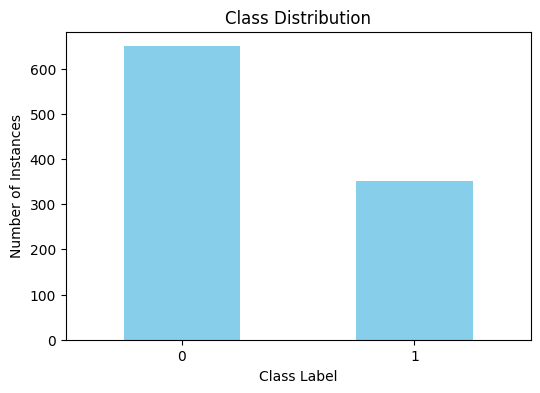


Class Proportions:
signature_label
0    0.649
1    0.351
Name: count, dtype: float64


In [ ]:
# CHECK CLASS DISTRIBUTION

import matplotlib.pyplot as plt

signature_lines_df_subset = signature_lines_df.iloc[:1000].copy()

class_distribution = signature_lines_df_subset["signature_label"].value_counts()

print("Class Distribution:")
print(class_distribution)

plt.figure(figsize=(6, 4))
class_distribution.plot(kind="bar", color="skyblue")
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Number of Instances")
plt.xticks(rotation=0)
plt.show()

class_proportions = class_distribution / len(signature_lines_df_subset)
print("\nClass Proportions:")
print(class_proportions)

To prepare the data for fine-tuning a BERT model on the task of email signature detection, a custom PyTorch dataset class named `EmailDataset` was implemented.

The EmailDataset class performs the following steps:

It tokenizes each email line using the pre-trained BERT tokenizer (`bert-base-uncased`), ensuring that the input text is truncated or padded to a fixed length of 64 tokens.

It returns a dictionary for each item containing:

* `input_ids`: token indices for the line.

* `attention_mask`: binary mask indicating which tokens are padding.

* `label`: the corresponding binary signature label, cast as a PyTorch tensor.

In [ ]:
# CREATE DATASET FOR BERT MODEL

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class EmailDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=64):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        text = row["body_lines"]
        label = row["signature_label"]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": torch.tensor(label, dtype=torch.long)
        }

dataset = EmailDataset(signature_lines_df_subset, tokenizer, max_len=64)
sample = dataset[0]
print("Input IDs:", sample["input_ids"].shape)
print("Attention Mask:", sample["attention_mask"].shape)
print("Labels:", sample["label"].shape)
print("Length of dataset:", len(dataset))
print(sample)

Input IDs: torch.Size([64])
Attention Mask: torch.Size([64])
Labels: torch.Size([])
Length of dataset: 1000
{'input_ids': tensor([  101,  2064,  2017,  4604,  2033,  1037,  6134,  1997,  1996, 10300,
         1998,  2504,  1997,  3071,  1999,  1996,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'label': tensor(0)}


I splitted the dataset into train and test datasets.

In [ ]:
# SPLIT INTO TRAIN AND TEST DATASETS

from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print(f"Dataset prepared: {len(train_dataset)} training samples, {len(test_dataset)} test samples.")

train_batch = next(iter(train_loader))
train_input_ids, train_attention_mask, train_labels = train_batch['input_ids'], train_batch['attention_mask'], train_batch['label']

print("Train Sample:")
print("Input IDs:", train_input_ids[0])
print("Attention Mask:", train_attention_mask[0])
print("Label:", train_labels[0])

test_batch = next(iter(test_loader))
test_input_ids, test_attention_mask, test_labels = test_batch['input_ids'], test_batch['attention_mask'], test_batch['label']

print("\nTest Sample:")
print("Input IDs:", test_input_ids[0])
print("Attention Mask:", test_attention_mask[0])
print("Label:", test_labels[0])

Dataset prepared: 800 training samples, 200 test samples.
Train Sample:
Input IDs: tensor([  101,  1045,  2903,  2008,  1037,  3460,  2013,  7367, 25698,  2078,
         2003,  2183,  2000,  2191,  2019,  3749,  1012,  2106,  2017,  3113,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
Attention Mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Label: tensor(0)

Test Sample:
Input IDs: tensor([ 101, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027,
        1027, 1027, 1027, 1027, 1027, 1027, 1027, 1027, 1

The code defines a neural network model, `BertForSignatureClassification`, designed to classify whether a given line of text in an email is part of a signature or not. The model is based on a pre-trained BERT architecture (`bert-base-uncased`).

The model loads the pre-trained BERT encoder from the `HuggingFace Transformers` library. On top of the BERT model, a fully connected linear layer is added to perform binary classification. The output dimension of the classifier is set to 2, corresponding to the two target classes: signature line (label 1) or non-signature line (label 0).

During the `forward` method, the model takes two inputs:

* `input_ids`: the tokenized input text

* `attention_mask`: a mask to distinguish real tokens from padding tokens
These inputs are passed through the BERT encoder, and the resulting contextual embeddings are summarized using the output corresponding to the `[CLS]` token (the `pooled_output`). This vector is then passed through the classifier layer to generate a prediction (`logits`) for each input sample.


In [ ]:
# SIGNATURE CLASSIFIER

import torch
import torch.nn as nn
from transformers import BertModel

class BertForSignatureClassification(nn.Module):
    def __init__(self, model_name="bert-base-uncased"):
        super(BertForSignatureClassification, self).__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        logits = self.classifier(pooled_output)
        return logits

The code outlines the process for training a BERT-based model `BertForSignatureClassification` to classify email signatures.

The code first checks whether a CUDA-enabled `GPU` is available, and sets the device to either cuda (`GPU`) or cpu accordingly. This allows the model to be trained on a `GPU` if available, which significantly speeds up training for deep learning models.

The loss function used is `CrossEntropyLoss`, which is standard for classification tasks, as it computes the loss between the predicted class probabilities and the true class labels.

The optimizer `Adam` is used with a learning rate of 2e-5. `Adam` is a popular optimization algorithm for training deep learning models due to its efficiency and adaptive learning rate.

To improve training performance and reduce memory usage, the code leverages mixed precision training using `autocast` and `GradScaler` from `PyTorch`. Mixed precision allows for faster computation, improving the training speed on GPUs without sacrificing model accuracy.

The train_model function defines the training loop over a specified number of epochs (default 3 epochs).

In each epoch, the model processes batches of data from the `train_loader`. For each batch, the input data (`input_ids` and `attention_mask`) and corresponding labels are moved to the device (`GPU`/`CPU`).

The results of loss function are decreasing from 0.3564 to 0.1024 over 3 epochs that is a good indicator that the model is learning effectively.










In [ ]:
# TRAINING THE MODEL

from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSignatureClassification().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

scaler = GradScaler()

def train_model(model, train_loader, criterion, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch in train_loader:
            input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

train_model(model, train_loader, criterion, optimizer)

<ipython-input-37-2dbb788400f8>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/usr/local/lib/python3.11/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
<ipython-input-37-2dbb788400f8>:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.11/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1, Loss: 0.3564252107590437
Epoch 2, Loss: 0.15370155446231365
Epoch 3, Loss: 0.10244566595181823


I evaluated the model performace and received the following results:

* Accuracy: 96.50%. The model accurately predicted 96.5% of the email signature classification cases, demonstrating strong performance.

* Precision: 93.51%. Precision indicates that 93.51% of the predictions made for the "Signature" class were correct, meaning that the model is good at identifying actual signatures without many false positives.

* Recall: 97.30% Recall shows that 97.30% of the actual signatures were correctly identified by the model, suggesting that the model has a low rate of false negatives.

* F1-Score: 95.36%. The F1-score, which is the harmonic mean of precision and recall, is 95.36%, indicating that the model maintains a good balance between precision and recall.

Accuracy: 0.9650
Precision: 0.9351
Recall: 0.9730
F1-Score: 0.9536
Confusion Matrix:
[[121   5]
 [  2  72]]


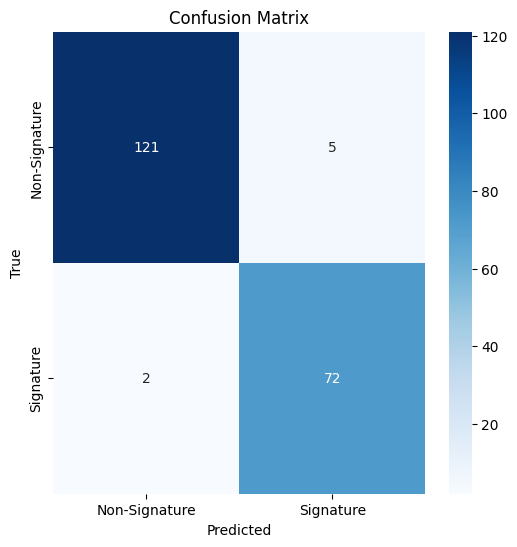

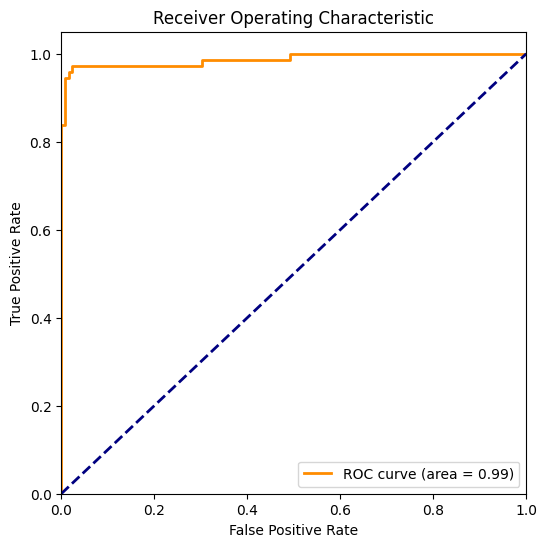

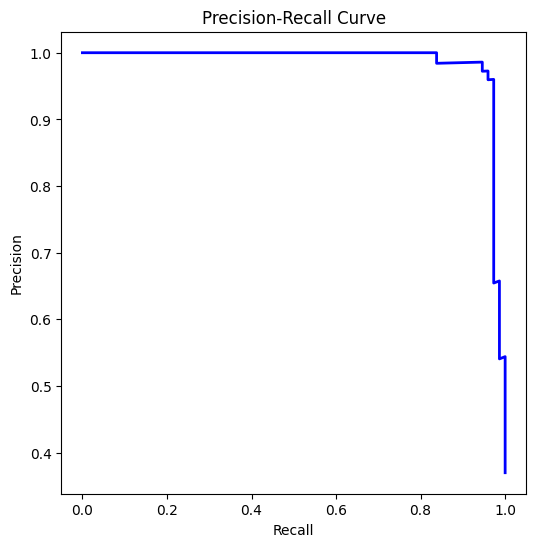

In [ ]:
# MODEL EVALUATION

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(6, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Signature", "Signature"], yticklabels=["Non-Signature", "Signature"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def plot_roc_curve(all_labels, all_predictions):
    fpr, tpr, _ = roc_curve(all_labels, all_predictions)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

def plot_precision_recall_curve(all_labels, all_predictions):
    precision, recall, _ = precision_recall_curve(all_labels, all_predictions)

    plt.figure(figsize=(6, 6))
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()

def evaluate_model_with_plots(model, test_loader, device):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask, labels = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["label"].to(device)

            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)[:, 1]
            _, predictions = torch.max(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

    plot_confusion_matrix(conf_matrix)
    plot_roc_curve(all_labels, all_probs)
    plot_precision_recall_curve(all_labels, all_probs)

evaluate_model_with_plots(model, test_loader, device)


In [ ]:
# SAVE THE MODEL

torch.save(model.state_dict(), "/content/drive/My Drive/NLP/signature_classifier.pth")

# *Section XI. Topic Modelling*.





Topic modeling is a method for unsupervised classification of documents, similar to clustering on numeric data. It helps identify some natural groups of topics even when the specific themes do not in advance.

To prepare the data for topic modelling, I first refined the format of the email messages. Since email signatures and the greetings do not contribute to defining the topic and contain only non-essential information, I remove it to improve the clarity and relevance of the data.

In [ ]:
# REMOVE SIGNATURES AND FIRST ROW

import pandas as pd

parsed_emails_topic_modelling = pd.read_csv("/content/drive/My Drive/NLP/parsed_emails_pleasantries_signatures.csv")

#parsed_emails_topic_modelling = parsed_emails_pleasantries_signatures.copy()

parsed_emails_topic_modelling["clean_from_patterns"] = parsed_emails_topic_modelling["clean_from_patterns"].fillna("").astype(str)
parsed_emails_topic_modelling["signature"] = parsed_emails_topic_modelling["signature"].fillna("").astype(str)
parsed_emails_topic_modelling["polite_phrases"] = parsed_emails_topic_modelling["polite_phrases"].fillna("").astype(str)

parsed_emails_topic_modelling["clean_for_topic"] = parsed_emails_topic_modelling.apply(
    lambda row: row["clean_from_patterns"].replace(row["signature"], "").strip(), axis=1
)

parsed_emails_topic_modelling["clean_for_topic"] = parsed_emails_topic_modelling.apply(
    lambda row: row["clean_from_patterns"].replace(row["polite_phrases"], "").strip(), axis=1
)

def remove_short_first_row(text):
    lines = text.split("\n")
    if len(lines) > 1 and len(lines[0].split()) <= 2:
        return "\n".join(lines[1:]).strip()
    return text

parsed_emails_topic_modelling["clean_for_topic"] = parsed_emails_topic_modelling["clean_for_topic"].apply(remove_short_first_row)
parsed_emails_topic_modelling.head(5)

,file,message,body,date,from,to,subject,clean_from_patterns,clean_for_pleasantries,greeting_sentences,body_sentences,closing_sentences,polite_phrases,signature,clean_for_topic
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,Mime-Version: 1.0,here is our forecast,here is our forecast,[],[],[],[],,here is our forecast
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,traveling to have a business meeting takes the...,traveling to have a business meeting takes the...,[],[],[],[],,traveling to have a business meeting takes the...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!,test successful. way to go!!!,[],[],[],[],,test successful. way to go!!!
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"randy,\n\n can you send me a schedule of the s...",randy\n\n can you send me a schedule of the sa...,[],[],[],[],phillip,can you send me a schedule of the salary and l...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,let's shoot for tuesday at 11:45.,lets shoot for tuesday at .,[],[],[],[],,let's shoot for tuesday at 11:45.


In [ ]:
print(parsed_emails_topic_modelling.loc[208, 'body'])

---------------------- Forwarded by Phillip K Allen/HOU/ECT on 03/22/2000 
01:46 PM ---------------------------
   
	
	
	From:  Colleen Sullivan                           03/22/2000 08:42 AM
	

To: Hunter S Shively/HOU/ECT@ECT, Phillip K Allen/HOU/ECT@ECT, Scott 
Neal/HOU/ECT@ECT, Thomas A Martin/HOU/ECT@ECT
cc: Bhavna Pandya/HOU/ECT@ECT 
Subject: Meeting-THURSDAY, MARCH 23 - 11:15 AM

Please plan on attending a meeting on Thursday, March 23 at 11:15 am in Room 
3127.  This meeting will be brief.  I would like to take the time to 
introduce Bhavna Pandya, and get some input from you on various projects she 
will be assisting us with.  Thank you.


I cleaned the text, tokenized, removed stopwords and stemmed the emails for the topic modelling.

In [ ]:
# CLEANING FOR TOPIC MODELLING

import re
import nltk
import spacy
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.util import ngrams
from collections import Counter

nltk.download('punkt_tab')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(body):
    if not isinstance(body, str):
        return ""
    # Remove words containing "@" or "&"
    body = re.sub(r"\S*[@&]\S*", "", body)
    # Remove words with a format like "comnes/pdx/ect@ect"
    body = re.sub(r"\S+(/\S+)+@\S+", "", body)
    # Improved URL removal regex
    body = re.sub(r"https?://[^\s]+|www\.[^\s]+", "", body)
    # Remove words consisting of the same repeated letter
    body = re.sub(r"\b([a-zA-Z])\1+\b", "", body)
    # Remove HTML tags
    body = re.sub(r"<.*?>", "", body)
    # Remove \t and \n
    body = re.sub(r"[\t\n]+", " ", body)
    # Remove numbers
    body = re.sub(r"\d+", "", body)
    # Remove words consisting of one or two letters
    body = re.sub(r"\b\w{1,2}\b", "", body)
    # Remove punctuation (except spaces)
    body = re.sub(r"\s+", " ", body).strip()
    body = body.lower()
    # Remove extra spaces again after deletions
    body = re.sub(r"\s+", " ", body).strip()
    words = word_tokenize(body.lower())
    words = [word for word in words if "_" not in word]
    words = [word for word in words if word.isalnum() and word not in stop_words]
    stemmed_words = [stemmer.stem(word) for word in words]
    doc = nlp(" ".join(words))
    lemmatized_words = [token.lemma_ for token in doc if token.pos_ in ['NOUN', 'ADJ', 'VERB']]
    return " ".join(lemmatized_words)

parsed_emails_topic_modelling["processed_body"] = parsed_emails_topic_modelling["clean_for_topic"].apply(preprocess_text)
parsed_emails_topic_modelling.to_csv("/content/drive/My Drive/NLP/processed_emails_topics.csv", index=False)
parsed_emails_topic_modelling.head(5)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,file,message,body,date,from,to,subject,clean_from_patterns,clean_for_pleasantries,greeting_sentences,body_sentences,closing_sentences,polite_phrases,signature,clean_for_topic,processed_body
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,Mime-Version: 1.0,here is our forecast,here is our forecast,[],[],[],[],,here is our forecast,
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,traveling to have a business meeting takes the...,traveling to have a business meeting takes the...,[],[],[],[],,traveling to have a business meeting takes the...,travel business meeting take fun trip prepare ...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!,test successful. way to go!!!,[],[],[],[],,test successful. way to go!!!,test successful way
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"randy,\n\n can you send me a schedule of the s...",randy\n\n can you send me a schedule of the sa...,[],[],[],[],phillip,can you send me a schedule of the salary and l...,send schedule salary level scheduling group th...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,let's shoot for tuesday at 11:45.,lets shoot for tuesday at .,[],[],[],[],,let's shoot for tuesday at 11:45.,let shoot


In [ ]:
import pandas as pd

parsed_emails_topic_modelling = pd.read_csv("/content/drive/My Drive/NLP/processed_emails_topics.csv")
parsed_emails_topic_modelling.head(5)

parsed_emails_topic_modelling["processed_body"] = parsed_emails_topic_modelling["processed_body"].astype(str).apply(
    lambda x: " ".join([word for word in x.split() if "_" not in word]) if isinstance(x, str) else ""
)

In [ ]:
# CHECK_1 NAN ROWS

import pandas as pd

parsed_emails_topic_modelling_empty = parsed_emails_topic_modelling[parsed_emails_topic_modelling['processed_body'].isna() & (parsed_emails_topic_modelling['processed_body'] == '')]
parsed_emails_topic_modelling_empty

,file,message,body,date,from,to,subject,clean_from_patterns,clean_for_pleasantries,greeting_sentences,body_sentences,closing_sentences,polite_phrases,signature,clean_for_topic,processed_body


In [ ]:
# CHECK_2 NAN ROWS

import pandas as pd

nan_rows = parsed_emails_topic_modelling.loc[parsed_emails_topic_modelling['processed_body'].isna()]
nan_rows

,file,message,body,date,from,to,subject,clean_from_patterns,clean_for_pleasantries,greeting_sentences,body_sentences,closing_sentences,polite_phrases,signature,clean_for_topic,processed_body


In [ ]:
# CHECK_3 NAN ROWS

import pandas as pd

parsed_emails_topic_modelling[parsed_emails_topic_modelling["processed_body"] == "nan"]

,file,message,body,date,from,to,subject,clean_from_patterns,clean_for_pleasantries,greeting_sentences,body_sentences,closing_sentences,polite_phrases,signature,clean_for_topic,processed_body
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,Mime-Version: 1.0,here is our forecast,here is our forecast,[],[],[],[],NaN,here is our forecast,nan
49,allen-p/_sent_mail/139.,Message-ID: <9942513.1075855688311.JavaMail.ev...,http://www.hearme.com/vc2/?chnlOwnr=pallen@enr...,"Tue, 12 Sep 2000 00:27:00 -0700 (PDT)",phillip.allen@enron.com,moshuffle@hotmail.com,Mime-Version: 1.0,http://www.hearme.com/vc2/?chnlownr=pallen@enr...,NaN,[],[],[],[],NaN,http://www.hearme.com/vc2/?chnlownr=pallen@enr...,nan
73,allen-p/_sent_mail/160.,Message-ID: <29777670.1075855688771.JavaMail.e...,John Lavorato-M\n\nMike Grigsby-D\nKeith Holst...,"Thu, 31 Aug 2000 05:02:00 -0700 (PDT)",phillip.allen@enron.com,debe@fsddatasvc.com,Mime-Version: 1.0,john lavorato-m\n\nmike grigsby-d\nkeith holst...,john lavoratom\n\nmike grigsbyd\nkeith holstd\...,[],[],[],[],NaN,mike grigsby-d\nkeith holst-d\nfrank ermis-d\n...,nan
149,allen-p/_sent_mail/231.,Message-ID: <23290954.1075855690306.JavaMail.e...,Anytime after 3 p.m.,"Fri, 7 Jul 2000 06:41:00 -0700 (PDT)",phillip.allen@enron.com,felix.buitron@enron.com,Re: Memory,anytime after 3 p.m.,anytime after p.m.,[],[],[],[],NaN,anytime after 3 p.m.,nan
157,allen-p/_sent_mail/239.,Message-ID: <20364402.1075855690481.JavaMail.e...,no,"Mon, 26 Jun 2000 07:13:00 -0700 (PDT)",phillip.allen@enron.com,stouchstone@natsource.com,Re:,no,no,[],[],[],[],NaN,no,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4764,arnold-j/all_documents/927.,Message-ID: <12399283.1075857611716.JavaMail.e...,---------------------- Forwarded by John Arnol...,"Sun, 11 Feb 2001 23:29:00 -0800 (PST)",john.arnold@enron.com,mike.maggi@enron.com,Natural update,\n\n\nfyi\n - ng2001-0211.doc,fyi\n ng.doc,[],[],[],[],NaN,- ng2001-0211.doc,nan
4770,arnold-j/all_documents/932.,Message-ID: <32843604.1075857611825.JavaMail.e...,can you change #23 and #375 to Nymex,"Fri, 9 Feb 2001 04:33:00 -0800 (PST)",john.arnold@enron.com,errol.mclaughlin@enron.com,Mime-Version: 1.0,can you change #23 and #375 to nymex,can you change and to nymex,[],[],[],[],NaN,can you change #23 and #375 to nymex,nan
4799,arnold-j/all_documents/959.,Message-ID: <33007933.1075857612424.JavaMail.e...,---------------------- Forwarded by John Arnol...,"Sun, 4 Feb 2001 13:15:00 -0800 (PST)",john.arnold@enron.com,mike.maggi@enron.com,Natural update,\n\n\n?\n - ng2001-0204.doc,?\n ng.doc,[],[],[],[],NaN,- ng2001-0204.doc,nan
4820,arnold-j/all_documents/979.,Message-ID: <24107484.1075857612885.JavaMail.e...,83,"Wed, 24 Jan 2001 00:07:00 -0800 (PST)",john.arnold@enron.com,michael.byrne@americas.bnpparibas.com,Re: BNP PARIBAS Commodity Futures Weekly AGA S...,83,NaN,[],[],[],[],NaN,83,nan


In [ ]:
# REMOVE NAN VALUES

parsed_emails_topic_modelling = parsed_emails_topic_modelling[parsed_emails_topic_modelling["processed_body"] != "nan"]
parsed_emails_topic_modelling.head(5)

,file,message,body,date,from,to,subject,clean_from_patterns,clean_for_pleasantries,greeting_sentences,body_sentences,closing_sentences,polite_phrases,signature,clean_for_topic,processed_body
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,traveling to have a business meeting takes the...,traveling to have a business meeting takes the...,[],[],[],[],NaN,traveling to have a business meeting takes the...,travel business meeting take fun trip prepare ...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!,test successful. way to go!!!,[],[],[],[],NaN,test successful. way to go!!!,test successful way
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"randy,\n\n can you send me a schedule of the s...",randy\n\n can you send me a schedule of the sa...,[],[],[],[],phillip,can you send me a schedule of the salary and l...,send schedule salary level scheduling group th...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,let's shoot for tuesday at 11:45.,lets shoot for tuesday at .,[],[],[],[],NaN,let's shoot for tuesday at 11:45.,let shoot
5,allen-p/_sent_mail/1002.,Message-ID: <30965995.1075863688265.JavaMail.e...,"Greg,\n\n How about either next Tuesday or Thu...","Thu, 31 Aug 2000 04:17:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,"greg,\n\n how about either next tuesday or thu...",greg\n\n how about either next tuesday or thur...,[],[],[],[],NaN,how about either next tuesday or thursday?\n\n...,next


To enhance topic modeling, I generated bigrams and trigrams from the preprocessed email bodies using `nltk` library. Bigrams (two-word combinations) and trigrams (three-word combinations) help capture meaningful word patterns and context that may not be evident from single words alone.



In [ ]:
# GENERATE BIGRAMS & TRIGRAMS

import re
import nltk
import spacy
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.util import ngrams
from collections import Counter

nltk.download('punkt_tab')
nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

parsed_emails_topic_modelling = parsed_emails_topic_modelling.dropna(subset=['processed_body'])

def generate_ngrams(text, n):
    words = word_tokenize(text.lower())
    words = [word for word in words if word.isalnum() and word not in stop_words]
    return list(ngrams(words, n))

parsed_emails_topic_modelling["bigrams"] = parsed_emails_topic_modelling["processed_body"].apply(lambda x: generate_ngrams(x, 2))
parsed_emails_topic_modelling["trigrams"] = parsed_emails_topic_modelling["processed_body"].apply(lambda x: generate_ngrams(x, 3))
parsed_emails_topic_modelling.head(5)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,file,message,body,date,from,to,subject,clean_from_patterns,clean_for_pleasantries,greeting_sentences,body_sentences,closing_sentences,polite_phrases,signature,clean_for_topic,processed_body,bigrams,trigrams
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,traveling to have a business meeting takes the...,traveling to have a business meeting takes the...,[],[],[],[],NaN,traveling to have a business meeting takes the...,travel business meeting take fun trip prepare ...,"[(travel, business), (business, meeting), (mee...","[(travel, business, meeting), (business, meeti..."
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!,test successful. way to go!!!,[],[],[],[],NaN,test successful. way to go!!!,test successful way,"[(test, successful), (successful, way)]","[(test, successful, way)]"
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"randy,\n\n can you send me a schedule of the s...",randy\n\n can you send me a schedule of the sa...,[],[],[],[],phillip,can you send me a schedule of the salary and l...,send schedule salary level scheduling group th...,"[(send, schedule), (schedule, salary), (salary...","[(send, schedule, salary), (schedule, salary, ..."
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,let's shoot for tuesday at 11:45.,lets shoot for tuesday at .,[],[],[],[],NaN,let's shoot for tuesday at 11:45.,let shoot,"[(let, shoot)]",[]
5,allen-p/_sent_mail/1002.,Message-ID: <30965995.1075863688265.JavaMail.e...,"Greg,\n\n How about either next Tuesday or Thu...","Thu, 31 Aug 2000 04:17:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,"greg,\n\n how about either next tuesday or thu...",greg\n\n how about either next tuesday or thur...,[],[],[],[],NaN,how about either next tuesday or thursday?\n\n...,next,[],[]


For the analysis, I computed statistics on the frequency of tokens, bigrams and trigrams, including the frequency of bigrams and trigrams where all words are the same. I observed that the token `image` frequently appears in the bigrams and trigrams. However, this term typically refers to the attached image and do not contribute to the topic modelling, as it is not relevant to the content or theme of the email.

In [ ]:
# STATISTICS FOR FREQUENCY OF TOKENS, BIGRAMS AND TRIGRAMS

import pandas as pd
from collections import Counter
from itertools import chain

parsed_emails_topic_modelling['tokens'] = parsed_emails_topic_modelling['processed_body'].apply(lambda x: x.split())

all_words = list(chain.from_iterable(parsed_emails_topic_modelling['tokens']))
all_bigrams = list(chain.from_iterable(parsed_emails_topic_modelling['bigrams']))
all_trigrams = list(chain.from_iterable(parsed_emails_topic_modelling['trigrams']))

word_freq = Counter(all_words)
bigram_freq = Counter(all_bigrams)
trigram_freq = Counter(all_trigrams)

most_common_words = word_freq.most_common(20)
most_common_bigrams = bigram_freq.most_common(20)
most_common_trigrams = trigram_freq.most_common(20)

words_df = pd.DataFrame(most_common_words, columns=['tokens', 'count_tokens'])
bigrams_df = pd.DataFrame(most_common_bigrams, columns=['bigrams', 'count_bigrams'])
trigrams_df = pd.DataFrame(most_common_trigrams, columns=['trigrams', 'count_trigrams'])

total_tokens = sum(word_freq.values())
total_bigrams = sum(bigram_freq.values())
total_trigrams = sum(trigram_freq.values())

words_df['percentage_tokens'] = (words_df['count_tokens'] / total_tokens * 100).round(2)
bigrams_df['percentage_bigrams'] = (bigrams_df['count_bigrams'] / total_bigrams * 100).round(2)
trigrams_df['percentage_trigrams'] = (trigrams_df['count_trigrams'] / total_trigrams * 100).round(2)

token_bigrams_trigrams_stat = pd.concat([words_df, bigrams_df, trigrams_df], axis=1)
token_bigrams_trigrams_stat

,tokens,count_tokens,percentage_tokens,bigrams,count_bigrams,percentage_bigrams,trigrams,count_trigrams,percentage_trigrams
0,gas,2006,0.70,"(image, image)",1357,0.48,"(image, image, image)",1098,0.40
1,image,1992,0.69,"(let, know)",481,0.17,"(global, strategic, source)",86,0.03
2,get,1973,0.69,"(natural, gas)",413,0.15,"(creekside, builder, llc)",75,0.03
3,price,1639,0.57,"(last, year)",232,0.08,"(order, instruction, transmit)",70,0.03
4,thank,1550,0.54,"(gas, price)",210,0.07,"(feel, free, call)",68,0.02
5,time,1482,0.52,"(next, week)",200,0.07,"(downgrade, buy, strong)",65,0.02
6,market,1358,0.47,"(make, sure)",162,0.06,"(buy, strong, buy)",64,0.02
7,say,1342,0.47,"(last, week)",148,0.05,"(global, market, fundamental)",64,0.02
8,use,1312,0.46,"(strong, buy)",145,0.05,"(see, attach, file)",62,0.02
9,call,1312,0.46,"(phillip, allen)",143,0.05,"(natural, gas, price)",60,0.02


In [ ]:
# FILTER BIGRAMS WHERE BOTH WORDS ARE THE SAME

filtered_bigrams = [bigram for bigram in all_bigrams if bigram[0] == bigram[1]]
unique_filtered_bigrams = set(filtered_bigrams)
for bigram in unique_filtered_bigrams:
    print(bigram)

('answer', 'answer')
('get', 'get')
('credit', 'credit')
('coal', 'coal')
('vessel', 'vessel')
('flight', 'flight')
('click', 'click')
('call', 'call')
('etol', 'etol')
('polymer', 'polymer')
('phillip', 'phillip')
('mery', 'mery')
('broker', 'broker')
('rule', 'rule')
('post', 'post')
('locate', 'locate')
('night', 'night')
('fee', 'fee')
('index', 'index')
('major', 'major')
('meeting', 'meeting')
('need', 'need')
('check', 'check')
('demand', 'demand')
('risk', 'risk')
('crap', 'crap')
('datum', 'datum')
('guide', 'guide')
('communication', 'communication')
('declare', 'declare')
('energy', 'energy')
('envoy', 'envoy')
('rich', 'rich')
('problem', 'problem')
('border', 'border')
('storage', 'storage')
('lien', 'lien')
('program', 'program')
('loss', 'loss')
('time', 'time')
('otmp', 'otmp')
('sic', 'sic')
('system', 'system')
('disagree', 'disagree')
('conversion', 'conversion')
('login', 'login')
('player', 'player')
('confidential', 'confidential')
('car', 'car')
('interior', 'int

In [ ]:
# FILTER TRIGRAMS WHERE ALL WORDS ARE THE SAME

filtered_trigrams = [trigram for trigram in all_trigrams if trigram[0] == trigram[1] == trigram[2]]
unique_filtered_trigrams = set(filtered_trigrams)
for trigram in unique_filtered_trigrams:
    print(trigram)

('sit', 'sit', 'sit')
('session', 'session', 'session')
('phase', 'phase', 'phase')
('badge', 'badge', 'badge')
('image', 'image', 'image')
('showtime', 'showtime', 'showtime')
('disagree', 'disagree', 'disagree')
('week', 'week', 'week')
('toy', 'toy', 'toy')
('day', 'day', 'day')
('cut', 'cut', 'cut')
('lot', 'lot', 'lot')
('call', 'call', 'call')
('miss', 'miss', 'miss')
('pager', 'pager', 'pager')
('reminder', 'reminder', 'reminder')
('send', 'send', 'send')
('give', 'give', 'give')
('spot', 'spot', 'spot')
('product', 'product', 'product')
('invite', 'invite', 'invite')
('settle', 'settle', 'settle')
('request', 'request', 'request')
('year', 'year', 'year')
('root', 'root', 'root')
('confidential', 'confidential', 'confidential')
('ghost', 'ghost', 'ghost')


I generated a word cloud to visualize word frequency and gain insights into the most commonly used terms in the dataset.

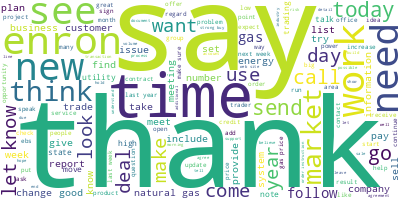

In [ ]:
# GENERATE WORD CLOUD

from wordcloud import WordCloud

#custom_stopwords = {"get", "call", "need", "work", "year", "know", "email",
#                    "today", "time", "send", "meeting", "think", "week", "request",
#                    "new", "let", "want", "use", "image", "say", "lot", "give", "sit",
#                    "buy", "reminder", "day", "week", "thank", "see", "go", "look", "take"}

custom_stopwords = {"get", "image", "phillip", "allen"}

long_string = ','.join(parsed_emails_topic_modelling['processed_body'].dropna().values)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

wordcloud = WordCloud(
    background_color="white",
    max_words=5000,
    contour_width=3,
    contour_color='steelblue',
    stopwords=custom_stopwords
)

wordcloud.generate(long_string)
wordcloud.to_image()

In [ ]:
!pip install gensim

  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)


I created the Dictionary consisting with individual tokens, bigrams and trigrams filtering out extremely rare terms (`no_below`=5) and overly common terms (`no_above`=0.5) using `gensim` library to reduce noise and increase model quality.
Finally, I transformed each document into a Bag-of-Words (BoW) representation using the dictionary. This corpus contains word frequency information that will be used by topic modeling algorithms to identify patterns across the dataset.

In [ ]:
# CREATE DICTIONARY AND CORPUS

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.phrases import Phrases, Phraser

custom_stopwords = {"get", "enron", "image", "thank", "send", "work", "think", "know", "ebs", "message", "email", "company", "year", "phillip", "allen"} #0.478
#custom_stopwords = {"get", "image"}
#custom_stopwords = {"get", "enron", "image", "thank", "send", "work", "think", "know",
#                    "ebs", "message", "email", "company", "year", "need", "meeting",
#                    "day", "time", "week", "look", "regard", "good", "want","information",
#                    "let", "receive", "group", "today", "come", "contact", "note"}

texts = [
    [word for word in simple_preprocess(doc, deacc=True) if word not in STOPWORDS and word not in custom_stopwords]
    for doc in parsed_emails_topic_modelling["processed_body"].fillna("")
]

bigram = Phrases(texts, min_count=5, threshold=100)
trigram = Phrases(bigram[texts], min_count=5, threshold=100)

bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

texts_bigrams = [bigram_mod[doc] for doc in texts]
texts_trigrams = [
    [word for word in trigram_mod[bigram_mod[doc]] if "_" not in word]
    for doc in texts
]

id2word = corpora.Dictionary(texts_trigrams)
id2word.filter_extremes(no_below=5, no_above=0.5)

id2word.filter_tokens(bad_ids=[tokenid for tokenid, word in id2word.items() if "_" in word])

corpus = [id2word.doc2bow(text) for text in texts_trigrams]

In [ ]:
# 20 THE MOST FREQUENT WORDS IN THE DICTIONARY

from collections import Counter

word_counts = Counter([word for text in texts_trigrams for word in text])
print(word_counts.most_common(20))

[('gas', 1936), ('price', 1639), ('time', 1482), ('market', 1332), ('use', 1280), ('need', 1267), ('week', 1117), ('cost', 1115), ('new', 1101), ('buy', 1080), ('information', 1025), ('power', 1004), ('today', 956), ('day', 954), ('want', 943), ('look', 937), ('project', 912), ('meeting', 909), ('deal', 901), ('good', 888)]


In [ ]:
print("Sample tokenized texts:", texts_trigrams[:5])
print("Dictionary size:", len(id2word))
print("Corpus size:", len(corpus))

Sample tokenized texts: [['forecast'], ['travel', 'business', 'meeting', 'fun', 'trip', 'prepare', 'presentation', 'suggest', 'hold', 'business', 'plan', 'meeting', 'trip', 'formal', 'business', 'meeting', 'try', 'honest', 'opinion', 'trip', 'desire', 'necessary', 'far', 'business', 'meeting', 'productive', 'stimulate', 'discussion', 'different', 'group', 'presenter', 'speak', 'quiet', 'waiting', 'turn', 'meeting', 'hold', 'round', 'table', 'discussion', 'format', 'suggestion', 'play', 'golf', 'rent', 'ski', 'boat', 'jet', 'ski', 'fly', 'time'], ['test', 'successful', 'way'], ['schedule', 'salary', 'level', 'scheduling', 'group', 'thought', 'change', 'example'], ['let', 'shoot']]
Dictionary size: 4178
Corpus size: 4944


To uncover latent topics within the email dataset, I applied the Latent Dirichlet Allocation (LDA) algorithm using the Gensim library. The goal was to identify the optimal number of topics that provide coherent groupings of words representing semantically interpretable themes.

I trained multiple LDA models by varying the number of topics in the range of 3 to 9. For each model, I computed the coherence score in topic modeling to measure how interpretable the topics are to humans. In this case, topics are represented as the top N words with the highest probability of belonging to that particular topic. Briefly, the coherence score measures how similar these words are to each other.

The model training parameters included:

* `passes`=10: the number of complete passes through the corpus during training,

* `chunksize`=100: the number of documents to be processed at a time,

* `alpha`='auto' and `eta`=0.1: priors for document-topic and topic-word distributions, allowing the model to learn asymmetric distributions,

* `random_state`=100: to ensure reproducibility.

I utilized the `word2vec` model for the coherence score. This will introduce the semantic of the words in the score.

Basically, we want to measure our coherence based on two criteria:

* Intra-topic similarity – the similarity of words in the same topic.
* Inter-topic similarity – the similarity of words across different topics.

The idea is to maximize intra-topic and minimize inter-topic similarity. Also, by similarity, imply the cosine similarity between words represented by word2vec embedding.

After evaluating all models, the one with the highest coherence score was selected as the optimal topic model. The coherence scores across different topic numbers were plotted to visualize the model's performance and support the choice of the optimal number of topics.

Training LDA model with 3 topics...
Coherence Score for 3 topics: 0.6367397904396057
Training LDA model with 4 topics...
Coherence Score for 4 topics: 0.6337599754333496
Training LDA model with 5 topics...
Coherence Score for 5 topics: 0.6293462514877319
Training LDA model with 6 topics...
Coherence Score for 6 topics: 0.6422651410102844
Training LDA model with 7 topics...
Coherence Score for 7 topics: 0.6533668637275696
Training LDA model with 8 topics...
Coherence Score for 8 topics: 0.6519565582275391
Training LDA model with 9 topics...
Coherence Score for 9 topics: 0.656589925289154

Optimal number of topics: 9 with coherence score 0.656589925289154


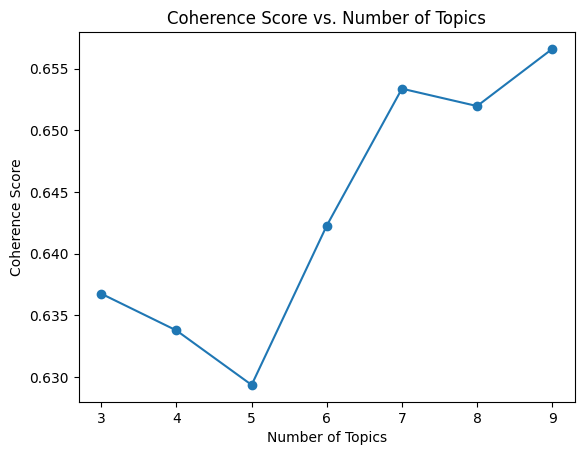

In [ ]:
# LDA MODEL - TOPIC MODELLING

from gensim.models.coherencemodel import CoherenceModel
import numpy as np

topic_range = range(3, 10, 1)
best_num_topics_lda = None
best_coherence_lda = -np.inf
coherence_scores_lda = []

for num_topics_lda in topic_range:
    print(f"Training LDA model with {num_topics_lda} topics...")

    lda_model = gensim.models.LdaModel(
        corpus=corpus,
        id2word=id2word,
        num_topics=num_topics_lda,
        random_state=100,
        update_every=1,
        chunksize=100,
        passes=10,
        alpha="auto",
        eta = 0.1,
        per_word_topics=True
    )

    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts_trigrams, coherence='c_w2v')
    coherence_score_lda = coherence_model_lda.get_coherence()
    coherence_scores_lda.append((num_topics_lda, coherence_score_lda))

    print(f"Coherence Score for {num_topics_lda} topics: {coherence_score_lda}")

    if coherence_score_lda > best_coherence_lda:
        best_coherence_lda = coherence_score_lda
        best_num_topics_lda = num_topics_lda
        best_model_lda = lda_model

print(f"\nOptimal number of topics: {best_num_topics_lda} with coherence score {best_coherence_lda}")

import matplotlib.pyplot as plt

num_topics_list_lda, scores_lda = zip(*coherence_scores_lda)
plt.plot(num_topics_list_lda, scores_lda, marker="o", linestyle="-")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.show()

In [ ]:
# GET THE DOMINANT TOPIC FOR EACH DOCUMENT FOR LDA TOPIC MODELLING

def get_dominant_topic(lda_model, corpus):
    dominant_topics = []
    for doc in corpus:
        topic_dist = lda_model.get_document_topics(doc)
        dominant_topic = max(topic_dist, key=lambda x: x[1])[0]
        dominant_topics.append(dominant_topic)
    return dominant_topics

dominant_topics_lda = get_dominant_topic(best_model_lda, corpus)
parsed_emails_topic_modelling['LDA_dominant_topic_id'] = dominant_topics_lda

def get_topic_keywords(lda_model, num_words=5):
    topic_keywords = {}
    for topic_id in range(lda_model.num_topics):
        words = lda_model.show_topic(topic_id, topn=num_words)
        topic_keywords[topic_id] = ", ".join([word for word, _ in words])
    return topic_keywords

topic_keywords_lda = get_topic_keywords(best_model_lda)

parsed_emails_topic_modelling['LDA_topic_keywords'] = parsed_emails_topic_modelling['LDA_dominant_topic_id'].map(topic_keywords_lda)
parsed_emails_topic_modelling[["processed_body", 'LDA_topic_keywords', 'LDA_dominant_topic_id']]

,processed_body,LDA_topic_keywords,LDA_dominant_topic_id
1,travel business meeting take fun trip prepare ...,"gas, energy, price, natural, electricity",8
2,test successful way,"meeting, information, receive, group, note",4
3,send schedule salary level scheduling group th...,"deal, time, look, day, want",3
4,let shoot,"deal, time, look, day, want",3
5,next,"deal, time, look, day, want",3
...,...,...,...
4939,high cautious service upgrade downgrade change...,"gas, energy, price, natural, electricity",8
4940,meet fre derek today let know need help thank ...,"deal, time, look, day, want",3
4941,click link happy hour invitation apb true quote,"meeting, information, receive, group, note",4
4942,eliminate specialization huge amount duplicati...,"deal, time, look, day, want",3


In [ ]:
# TOPICS FOR LDA TOPIC MODELLING

for topic_id_lda, words_lda in best_model_lda.print_topics(num_words=10):
    print(f"Topic {topic_id_lda}: {words_lda}")

Topic 0: 0.027*"product" + 0.023*"available" + 0.023*"free" + 0.020*"contact" + 0.020*"web" + 0.018*"enter" + 0.017*"click" + 0.016*"new" + 0.016*"site" + 0.016*"future"
Topic 1: 0.066*"confirm" + 0.061*"bmc" + 0.042*"consider" + 0.037*"water" + 0.030*"attend" + 0.029*"purchase" + 0.017*"job" + 0.017*"invoice" + 0.017*"standard" + 0.016*"past"
Topic 2: 0.060*"power" + 0.055*"buy" + 0.041*"market" + 0.037*"sell" + 0.030*"state" + 0.020*"weather" + 0.017*"plant" + 0.016*"global" + 0.016*"big" + 0.014*"lose"
Topic 3: 0.041*"deal" + 0.028*"time" + 0.026*"look" + 0.024*"day" + 0.023*"want" + 0.022*"good" + 0.021*"week" + 0.020*"need" + 0.016*"meet" + 0.016*"way"
Topic 4: 0.041*"meeting" + 0.040*"information" + 0.026*"receive" + 0.024*"group" + 0.023*"note" + 0.022*"team" + 0.018*"client" + 0.018*"need" + 0.018*"follow" + 0.017*"office"
Topic 5: 0.019*"report" + 0.019*"asset" + 0.016*"copyright" + 0.016*"reserve" + 0.015*"market" + 0.015*"change" + 0.015*"check" + 0.014*"service" + 0.013*"mo

In [ ]:
!pip install pyLDAvis

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 33.9 MB/s eta 0:00:00
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5


In [ ]:
# VISUALIZATION - LDA TOPIC MODELLING

import pyLDAvis
import pyLDAvis.gensim
import gensim

vis_lda = pyLDAvis.gensim.prepare(best_model_lda, corpus, id2word)

pyLDAvis.display(vis_lda)

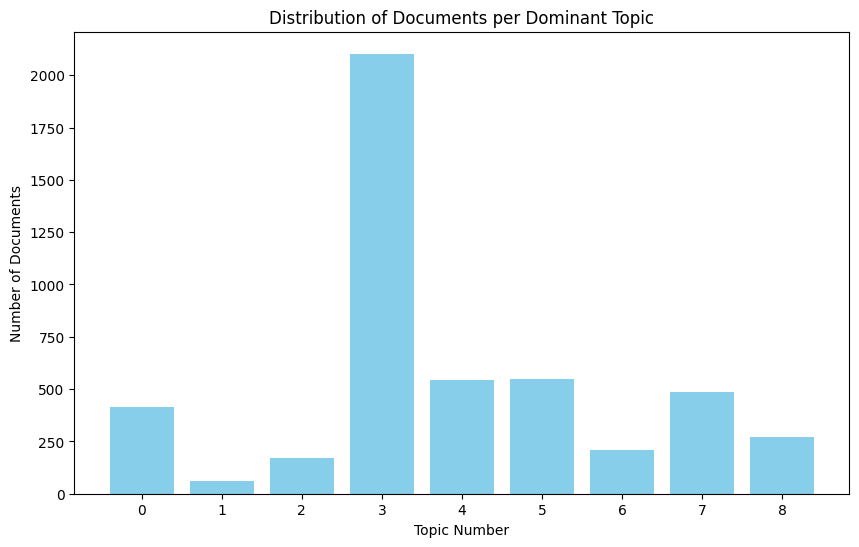

In [ ]:
# DISTRIBUTION OF DOCUMENTS PER DOMINANT TOPIC FOR LDA TOPIC MODELLING

import matplotlib.pyplot as plt

topic_counts_lda = parsed_emails_topic_modelling['LDA_dominant_topic_id'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(topic_counts_lda.index, topic_counts_lda.values, color='skyblue')
plt.xlabel('Topic Number')
plt.ylabel('Number of Documents')
plt.title('Distribution of Documents per Dominant Topic')
plt.xticks(topic_counts_lda.index)
plt.show()


NMF has two main advantages when compared to LDA. The first is that there are completely deterministic algorithms for its resolution. Second, NMF allows for an easier tuning and manipulation of its parameters.

Training NMF model with 3 topics...
Coherence Score for 3 topics: 0.5237261979021395
Training NMF model with 4 topics...
Coherence Score for 4 topics: 0.5069299788000357
Training NMF model with 5 topics...
Coherence Score for 5 topics: 0.4690636895651865
Training NMF model with 6 topics...
Coherence Score for 6 topics: 0.5184346815662262
Training NMF model with 7 topics...
Coherence Score for 7 topics: 0.5414501139627356
Training NMF model with 8 topics...
Coherence Score for 8 topics: 0.5837067392372496
Training NMF model with 9 topics...
Coherence Score for 9 topics: 0.5146560174744382

Optimal number of topics: 8 with coherence score 0.5837067392372496


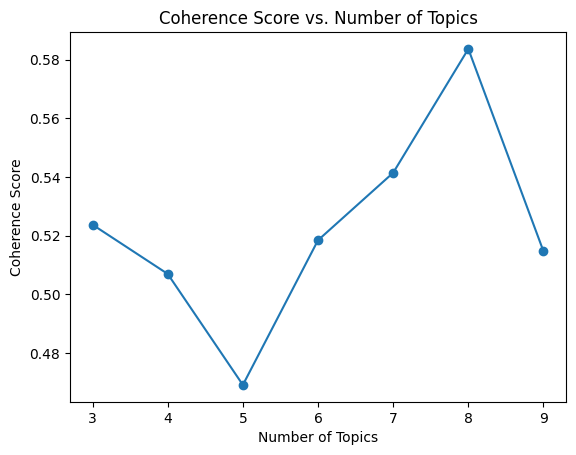

In [ ]:
# NMF MODEL - TOPIC MODELLING - DEFINE BEST NUMBER OF TOPICS

from gensim.corpora import Dictionary
from gensim.models.nmf import Nmf
from scipy.sparse import csc_matrix
import warnings
from operator import itemgetter

warnings.filterwarnings("ignore", category=DeprecationWarning, module='gensim')

topic_nums = range(3, 10, 1)

coherence_scores_nmf = []
best_coherence_nmf = -np.inf
best_num_topics_nmf = None
best_model_nmf = None

for num_nmf in topic_nums:
    print(f"Training NMF model with {num_nmf} topics...")
    nmf = Nmf(
        corpus=corpus,
        num_topics=num_nmf,
        id2word=id2word,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )

    cm_nmf = CoherenceModel(
        model=nmf,
        texts=texts_trigrams,
        dictionary=id2word,
        coherence='c_v'
    )
    coherence_score_nmf = cm_nmf.get_coherence()
    coherence_scores_nmf.append((num_nmf, coherence_score_nmf))

    print(f"Coherence Score for {num_nmf} topics: {coherence_score_nmf}")

    if coherence_score_nmf > best_coherence_nmf:
        best_coherence_nmf = coherence_score_nmf
        best_num_topics_nmf = num_nmf
        best_model_nmf = nmf

print(f"\nOptimal number of topics: {best_num_topics_nmf} with coherence score {best_coherence_nmf}")

import matplotlib.pyplot as plt

num_topics_list_nmf, scores_nmf = zip(*coherence_scores_nmf)  # Unpacking the tuples
plt.plot(num_topics_list_nmf, scores_nmf, marker="o", linestyle="-")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.show()

In [ ]:
#THE LIST OF NMF TOPICS

from nltk.tokenize import TweetTokenizer, RegexpTokenizer

def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]

def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)

def whitespace_tokenizer(text):
    pattern = r"(?u)\b\w\w+\b"
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens

def unique_words(text):
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist

docweights = nmf_tfidf.transform(tfidf_vectorizer.transform(texts_trigrams))

n_top_words = 5

topic_df = topic_table(
    nmf_tfidf,
    tfidf_fn,
    n_top_words
).T

topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1)
topic_df['topics'] = topic_df['topics'].str[0]
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x))
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])
topic_df['topics'] = topic_df['topics'].str[0]
topic_df['topics'] = topic_df['topics'].apply(lambda x: x if x else "No meaningful words")

for i, topic in enumerate(nmf_tfidf.components_):
    print(f"Topic {i}: ", [tfidf_fn[j] for j in topic.argsort()[:-6:-1]])

Topic 0:  ['meeting', 'information', 'time', 'receive', 'address']
Topic 1:  ['request', 'request request', 'resource', 'date request', 'create date']
Topic 2:  ['chart', 'contain', 'web', 'crude', 'future chart']
Topic 3:  ['gas', 'price', 'market', 'trade', 'buy']
Topic 4:  ['today', 'free', 'sign', 'fax', 'fax place sign']
Topic 5:  ['week', 'good', 'try', 'pay', 'let']
Topic 6:  ['file', 'attach', 'comment', 'comment attach', 'version']
Topic 7:  ['cost', 'loan', 'project', 'unit', 'construction']


In [ ]:
# TOPIC ASSIGHMENT TO THE EMAILS

import numpy as np

dominant_topics = np.argmax(docweights, axis=1)

topic_names = topic_df["topics"].tolist()
email_topics = [topic_names[i] for i in dominant_topics]

parsed_emails_topic_modelling["NMF_dominant_topic_id"] = dominant_topics
parsed_emails_topic_modelling["NMF_topic_keywords"] = email_topics

parsed_emails_topic_modelling.to_csv("/content/drive/My Drive/NLP/parsed_emails_topic_modelling.csv", index=False)
parsed_emails_topic_modelling[["processed_body", "NMF_dominant_topic_id", "NMF_topic_keywords"]].head(10)

,processed_body,NMF_dominant_topic_id,NMF_topic_keywords
0,forecast,3,gas price market trade buy
1,travel business meeting take fun trip prepare ...,0,meeting information time receive address
2,test successful way,3,gas price market trade buy
3,send schedule salary level scheduling group th...,0,meeting information time receive address
4,let shoot,5,week good try pay let
5,next phillip,0,meeting information time receive address
6,follow distribution list update phillip moniqu...,0,meeting information time receive address
7,morning,5,week good try pay let
8,think require static address company,0,meeting information time receive address
9,discuss phone conversation parallon microturbi...,3,gas price market trade buy


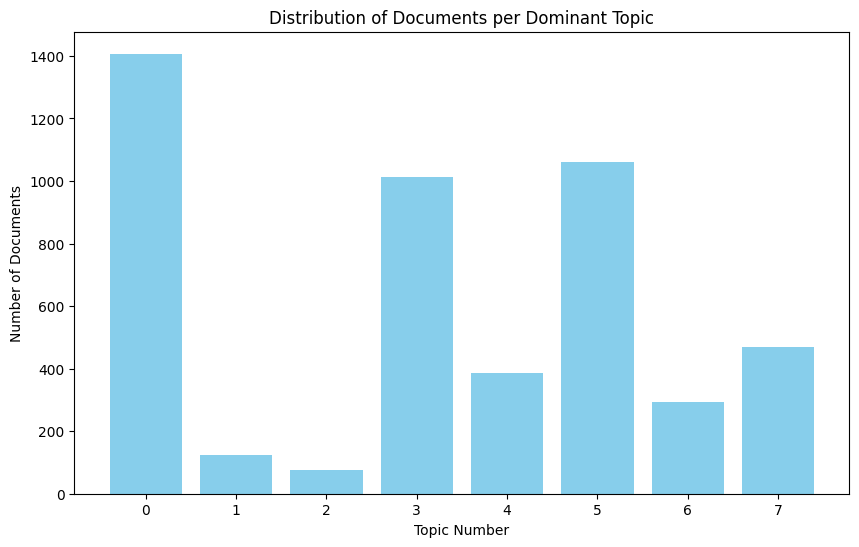

In [ ]:
# DISTRIBUTION OF DOCUMENTS PER DOMINANT TOPIC FOR NMF TOPIC MODELLING

import matplotlib.pyplot as plt

topic_counts_nmf = parsed_emails_topic_modelling['NMF_dominant_topic_id'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(topic_counts_nmf.index, topic_counts_nmf.values, color='skyblue')
plt.xlabel('Topic Number')
plt.ylabel('Number of Documents')
plt.title('Distribution of Documents per Dominant Topic')
plt.xticks(topic_counts_nmf.index)
plt.show()

# *Section XII. Argument Mining.*









I cleaned the text for the argument mining.

In [ ]:
# CLEANING THE TEXT

import re
import nltk
import spacy
import pandas as pd
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nlp = spacy.load("en_core_web_sm")
nltk.download('punkt_tab')
stemmer = PorterStemmer()
parsed_emails_argument_mining = pd.read_csv("/content/drive/My Drive/NLP/parsed_emails_topic_modelling.csv")

def preprocess_text(body):
    if not isinstance(body, str):
        return ""
    # Remove HTML tags
    body = BeautifulSoup(body, "html.parser").get_text()
    # Remove URLs
    body = re.sub(r"http\S+|www\S+|https\S+", '', body, flags=re.MULTILINE)
    # Remove email addresses
    body = re.sub(r'\S*@\S*\s?', '', body)
    # Remove special characters and digits
    body = re.sub(r"[^a-zA-Z\s\.\?\!_]", '', body)
    # Convert to lowercase
    body = body.lower()
    # Tokenization
    words = word_tokenize(body)
    # Remove stop words and words with underscores
    words = [word for word in words if '_' not in word]
    return words

parsed_emails_argument_mining["clean_for_argument_mining"] = parsed_emails_argument_mining["clean_from_patterns"].apply(preprocess_text)
#parsed_emails_argument_mining.to_csv("/content/drive/My Drive/NLP/processed_emails_argument_mining.csv", index=False)
parsed_emails_argument_mining.head(5)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,file,message,body,date,from,to,subject,clean_from_patterns,clean_for_pleasantries,greeting_sentences,...,clean_for_topic,processed_body,bigrams,trigrams,tokens,LDA_dominant_topic_id,LDA_topic_keywords,NMF_dominant_topic_id,NMF_topic_keywords,clean_for_argument_mining
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,Mime-Version: 1.0,here is our forecast,here is our forecast,[],...,here is our forecast,forecast,[],[],['forecast'],2,"time, day, information, week, good",3,gas price market trade buy,"[here, is, our, forecast]"
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,traveling to have a business meeting takes the...,traveling to have a business meeting takes the...,[],...,traveling to have a business meeting takes the...,travel business meeting take fun trip prepare ...,"[('travel', 'business'), ('business', 'meeting...","[('travel', 'business', 'meeting'), ('business...","['travel', 'business', 'meeting', 'take', 'fun...",2,"time, day, information, week, good",0,meeting information time receive address,"[traveling, to, have, a, business, meeting, ta..."
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!,test successful. way to go!!!,[],...,test successful. way to go!!!,test successful way,"[('test', 'successful'), ('successful', 'way')]","[('test', 'successful', 'way')]","['test', 'successful', 'way']",0,"gas, market, price, power, buy",3,gas price market trade buy,"[test, successful, ., way, to, go, !, !, !]"
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"randy,\n\n can you send me a schedule of the s...",randy\n\n can you send me a schedule of the sa...,[],...,can you send me a schedule of the salary and l...,send schedule salary level scheduling group th...,"[('send', 'schedule'), ('schedule', 'salary'),...","[('send', 'schedule', 'salary'), ('schedule', ...","['send', 'schedule', 'salary', 'level', 'sched...",1,"deal, meeting, service, regard, bmc",0,meeting information time receive address,"[randy, can, you, send, me, a, schedule, of, t..."
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,let's shoot for tuesday at 11:45.,lets shoot for tuesday at .,[],...,let's shoot for tuesday at 11:45.,let shoot,"[('let', 'shoot')]",[],"['let', 'shoot']",2,"time, day, information, week, good",5,week good try pay let,"[lets, shoot, for, tuesday, at, .]"


I split the messages by sentences.

In [ ]:
# SENTENCE SPLITTING

import spacy
import pandas as pd

nlp = spacy.load("en_core_web_sm")

def extract_sentences(text):
    if isinstance(text, list):
        text = " ".join(text)
    if not isinstance(text, str) or text.strip() == "":
        return []
    doc = nlp(text)
    return [sentence.text.strip() for sentence in doc.sents]

column_name = "clean_for_argument_mining"
if column_name in parsed_emails_argument_mining.columns:
    parsed_emails_argument_mining['sentences'] = parsed_emails_argument_mining[column_name].apply(extract_sentences)
else:
    print(f"Error: Column '{column_name}' not found in the dataset.")

parsed_emails_argument_mining.head(5)

,file,message,body,date,from,to,subject,clean_from_patterns,clean_for_pleasantries,greeting_sentences,...,processed_body,bigrams,trigrams,tokens,LDA_dominant_topic_id,LDA_topic_keywords,NMF_dominant_topic_id,NMF_topic_keywords,clean_for_argument_mining,sentences
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,Here is our forecast,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",phillip.allen@enron.com,tim.belden@enron.com,Mime-Version: 1.0,here is our forecast,here is our forecast,[],...,forecast,[],[],['forecast'],2,"time, day, information, week, good",3,gas price market trade buy,"[here, is, our, forecast]",[here is our forecast]
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,Traveling to have a business meeting takes the...,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",phillip.allen@enron.com,john.lavorato@enron.com,Re:,traveling to have a business meeting takes the...,traveling to have a business meeting takes the...,[],...,travel business meeting take fun trip prepare ...,"[('travel', 'business'), ('business', 'meeting...","[('travel', 'business', 'meeting'), ('business...","['travel', 'business', 'meeting', 'take', 'fun...",2,"time, day, information, week, good",0,meeting information time receive address,"[traveling, to, have, a, business, meeting, ta...",[traveling to have a business meeting takes th...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,test successful. way to go!!!,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!,test successful. way to go!!!,[],...,test successful way,"[('test', 'successful'), ('successful', 'way')]","[('test', 'successful', 'way')]","['test', 'successful', 'way']",0,"gas, market, price, power, buy",3,gas price market trade buy,"[test, successful, ., way, to, go, !, !, !]","[test successful ., way to go ! ! !]"
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,"Randy,\n\n Can you send me a schedule of the s...","Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",phillip.allen@enron.com,randall.gay@enron.com,Mime-Version: 1.0,"randy,\n\n can you send me a schedule of the s...",randy\n\n can you send me a schedule of the sa...,[],...,send schedule salary level scheduling group th...,"[('send', 'schedule'), ('schedule', 'salary'),...","[('send', 'schedule', 'salary'), ('schedule', ...","['send', 'schedule', 'salary', 'level', 'sched...",1,"deal, meeting, service, regard, bmc",0,meeting information time receive address,"[randy, can, you, send, me, a, schedule, of, t...",[randy can you send me a schedule of the salar...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,Let's shoot for Tuesday at 11:45.,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",phillip.allen@enron.com,greg.piper@enron.com,Re: Hello,let's shoot for tuesday at 11:45.,lets shoot for tuesday at .,[],...,let shoot,"[('let', 'shoot')]",[],"['let', 'shoot']",2,"time, day, information, week, good",5,week good try pay let,"[lets, shoot, for, tuesday, at, .]",[lets shoot for tuesday at .]


To support argumentative structure analysis within the email dataset, I implemented a rule-based approach to classify sentences into claims, premises, and major claims. This classification relies on the presence of indicative lexical patterns associated with each argumentative component.

The classification function processes each sentence, converting it to lowercase and checking whether any of the defined phrases occur. Based on the presence of these indicators, a sentence is labeled as one of the following:

* `is_claim`:  sentences containing claim indicators (e.g., `I believe`, `it seems to me`) signal subjective opinions or personal viewpoints.

* `is_premise`: sentences containing premise indicators (e.g., `because`, `since`, `as a result`) introduce justifications or reasoning behind a claim.

* `is_major_claim`: sentences containing major claim indicators (e.g., `clearly`, `it is undeniable`, `it is a fact that`) reflect strong, assertive statements often central to the overall argument.

The classification is applied to each sentence in the sentences column of the dataset, and results are stored in a new dataset `filtered_sentences_df`. If no indicators are detected, the sentence is ignored.

In [ ]:
# DATASET OF SENTENCES WITH CLAIMS, PREMISE AND MAJOR CLAIMS LABELS

import pandas as pd
import re

claim_keywords = {"i think", "i believe", "in my opinion", "it seems", "i feel",
    "from my perspective", "we should", "i would argue", "it is likely that",
    "it appears that", "to me", "i am convinced that", "it is my view that",
    "i am of the opinion that", "i assume", "one could argue", "i suspect",
    "there is reason to believe that", "my understanding is that",
    "i tend to think", "i am inclined to believe", "it is reasonable to say that",
    "i hold that", "it stands to reason that", "some may say", "arguably",
    "as far as i can tell", "personally", "my take is", "i propose",
    "it seems to me", "i hypothesize", "i advocate", "from my standpoint",
    "it is plausible that", "chances are that", "i contend that",
    "i wager that", "in my estimation", "i predict that", "i suppose",
    "it is safe to say that", "my position is that", "my belief is that"}

premise_keywords = {"because", "since", "as a result", "due to", "for this reason",
    "given that", "therefore", "thus", "hence", "consequently",
    "as", "on account of", "seeing that", "in view of", "considering that",
    "inasmuch as", "for the reason that", "owing to", "this is due to",
    "the reason being", "by virtue of", "on the grounds that",
    "which is why", "which means that", "in consequence", "following from",
    "stemming from", "deriving from", "resulting from", "thanks to",
    "being that", "as evidenced by", "as indicated by", "as implied by",
    "as shown by", "in light of the fact that"}

major_claim_keywords = {"clearly", "undoubtedly", "obviously", "it is certain",
    "it is evident", "everyone knows", "without a doubt",
    "there is no denying that", "it is undeniable", "it is indisputable",
    "it is a fact that", "it is beyond doubt", "it goes without saying",
    "there is no question that", "as everyone agrees", "as is well known",
    "it is well established that", "it stands to reason that",
    "it is universally acknowledged that", "it is beyond question",
    "one cannot deny that", "it is common knowledge that",
    "no one can dispute that", "it is an undeniable truth",
    "it is widely recognized that", "it is self-evident",
    "it is beyond argument", "it is beyond any doubt",
    "it is an accepted fact that", "it is an established fact that"}

rows = []

def contains_exact_phrase(text, phrases):
    return any(re.search(r'\b' + re.escape(phrase) + r'\b', text) for phrase in phrases)

for idx, row in parsed_emails_argument_mining.iterrows():
    if not isinstance(row["sentences"], list):
        continue

    for sent in row["sentences"]:
        if not isinstance(sent, str):
            continue

        sentence_lower = sent.lower()

        is_claim = contains_exact_phrase(sentence_lower, claim_keywords)
        is_premise = contains_exact_phrase(sentence_lower, premise_keywords)
        is_major_claim = contains_exact_phrase(sentence_lower, major_claim_keywords)

        rows.append({
            "email_id": row["email_id"] if "email_id" in row else idx,
            "sentence": sent,
            "is_claim": int(is_claim),
            "is_premise": int(is_premise),
            "is_major_claim": int(is_major_claim)
        })

sentences_df = pd.DataFrame(rows)

filtered_sentences_df = sentences_df[
    (sentences_df["is_claim"] == 1) |
    (sentences_df["is_premise"] == 1) |
    (sentences_df["is_major_claim"] == 1)
]
filtered_sentences_df = filtered_sentences_df.reset_index(drop=True)
filtered_sentences_df

,email_id,sentence,is_claim,is_premise,is_major_claim
0,1,as far as the business meetings i think it wou...,1,1,0
1,9,phillip as discussed during our phone conversa...,0,1,0
2,9,store number varies because of installation hu...,0,1,0
3,11,click on save as .,0,1,0
4,12,phillip below is the issues to do list as we g...,0,1,0
...,...,...,...,...,...
5488,4824,i think the specialization could remain but te...,1,0,0
5489,4825,as you know the enron management conference wi...,0,1,0
5490,4825,im delighted that general norman schwarzkopf w...,0,1,0
5491,4825,as ive said before we are a company that conti...,0,1,0


To enhance the linguistic analysis of argumentative components within the emails, Part-of-Speech (POS) tagging and syntactic dependency parsing were applied to all previously classified argumentative sentences (claims, premises, and major claims).

Using the `SpaCy` library and the `en_core_web_sm` English language model, the analyze_sentence function processes each sentence to extract:

* POS tags: Each word is labeled with its grammatical role (e.g., noun, verb, adjective), providing insight into the structure of the argument.

* Dependency relations: The syntactic relationship between words is captured (e.g., subject, object, root), along with the head word to which each token is grammatically linked.

This analysis was applied to the sentence column of the dataset using the `analyze_sentence` function, which returns both the POS tags and dependency relations for each token. The results were stored in a new column called `pos_dependency_analysis`.

In [ ]:
# POS TAGGING AND DEPENDENCY PARSING FOR DATASET OF SENTENCES

import spacy
import pandas as pd

nlp = spacy.load("en_core_web_sm")

def analyze_sentence(sentence):
    doc = nlp(sentence)

    pos_tags = [(token.text, token.pos_) for token in doc]
    dependencies = [(token.text, token.dep_, token.head.text) for token in doc]

    return {"POS_Tags": pos_tags, "Dependencies": dependencies}

filtered_sentences_df["pos_dependency_analysis"] = filtered_sentences_df["sentence"].apply(analyze_sentence)
filtered_sentences_df.head()

,email_id,sentence,is_claim,is_premise,is_major_claim,pos_dependency_analysis
0,1,as far as the business meetings i think it wou...,1,1,0,"{'POS_Tags': [('as', 'ADV'), ('far', 'ADV'), (..."
1,9,phillip as discussed during our phone conversa...,0,1,0,"{'POS_Tags': [('phillip', 'PROPN'), ('as', 'SC..."
2,9,store number varies because of installation hu...,0,1,0,"{'POS_Tags': [('store', 'NOUN'), ('number', 'N..."
3,11,click on save as .,0,1,0,"{'POS_Tags': [('click', 'VERB'), ('on', 'ADP')..."
4,12,phillip below is the issues to do list as we g...,0,1,0,"{'POS_Tags': [('phillip', 'NOUN'), ('below', '..."


To further enhance the argumentative analysis of the sentences, the code implements a rule-based approach to extract argumentative relations—specifically, support, contrast, and causality—from syntactic dependency patterns.

The `extract_argument_flags` function operates on each row of the annotated dataset (`filtered_sentences_df`) and checks the dependency labels extracted in the previous parsing step (`pos_dependency_analysis`) alongside existing sentence-level annotations such as `is_claim`, `is_major_claim`, and `is_premise`.

Based on this information:

Causal Relations (`is_causal`):
If a sentence is marked as a claim or major claim and contains dependency relations involving causal discourse markers such as `because`, `since`, or `due` (linked via `mark`, `advcl`, or `prep` dependencies), it is flagged as `causal`.

Contrastive Relations (`is_contrastive`):
Similarly, sentences that include contrastive discourse markers like `but`, `however`, or although and show relevant dependencies (`cc` or `advmod`) are flagged as `contrastive`.

Support Relations (`is_support`):
Sentences marked as premises are checked for syntactic constructions that typically indicate supportive structures (e.g., `nsubj`, `ccomp`). If such relations are present, the sentence is marked as `support`.

In [ ]:
# EXTRACT THE ARGUMENT RELATION FOR DATASET OF SENTENCES

import pandas as pd

def extract_argument_flags(row):
    """Extracts boolean flags for different argument relationships."""
    pos_dependency_analysis = row["pos_dependency_analysis"]
    is_claim = row["is_claim"]
    is_premise = row["is_premise"]
    is_major_claim = row["is_major_claim"]

    is_causal = 0
    is_contrastive = 0
    is_support = 0

    if not pos_dependency_analysis or not isinstance(pos_dependency_analysis, dict):
        return pd.Series([is_support, is_contrastive, is_causal], index=["is_support", "is_contrastive", "is_causal"])

    dependencies = pos_dependency_analysis.get('Dependencies', [])

    if is_claim == 1 or is_major_claim == 1:
        if any(dep in ["mark", "advcl", "prep"] and token.lower() in ["because", "since", "due"]
               for token, dep, _ in dependencies):
            is_causal = 1
        if any(dep in ["cc", "advmod"] and token.lower() in ["but", "however", "although"]
               for token, dep, _ in dependencies):
            is_contrastive = 1

    if is_premise == 1:
        if any(dep in ["nsubj", "ccomp"] for _, dep, _ in dependencies):
            is_support = 1

    return pd.Series([is_support, is_contrastive, is_causal], index=["is_support", "is_contrastive", "is_causal"])

filtered_sentences_df[["is_support", "is_contrastive", "is_causal"]] = filtered_sentences_df.apply(extract_argument_flags, axis=1)
filtered_sentences_df.to_csv("/content/drive/My Drive/NLP/filtered_sentences_df.csv", index=False)
filtered_sentences_df.head(5)

,email_id,sentence,is_claim,is_premise,is_major_claim,pos_dependency_analysis,is_support,is_contrastive,is_causal
0,1,as far as the business meetings i think it wou...,1,1,0,"{'POS_Tags': [('as', 'ADV'), ('far', 'ADV'), (...",1,0,0
1,9,phillip as discussed during our phone conversa...,0,1,0,"{'POS_Tags': [('phillip', 'PROPN'), ('as', 'SC...",1,0,0
2,9,store number varies because of installation hu...,0,1,0,"{'POS_Tags': [('store', 'NOUN'), ('number', 'N...",1,0,0
3,11,click on save as .,0,1,0,"{'POS_Tags': [('click', 'VERB'), ('on', 'ADP')...",0,0,0
4,12,phillip below is the issues to do list as we g...,0,1,0,"{'POS_Tags': [('phillip', 'NOUN'), ('below', '...",1,0,0


# *Section XIII. Argument Mining Classifier.*









In [2]:
import pandas as pd

filtered_sentences_df = pd.read_csv("/content/drive/My Drive/NLP/filtered_sentences_df.csv")
filtered_sentences_df.head(5)

,email_id,sentence,is_claim,is_premise,is_major_claim,pos_dependency_analysis,is_support,is_contrastive,is_causal
0,1,as far as the business meetings i think it wou...,1,1,0,"{'POS_Tags': [('as', 'ADV'), ('far', 'ADV'), (...",1,0,0
1,9,phillip as discussed during our phone conversa...,0,1,0,"{'POS_Tags': [('phillip', 'PROPN'), ('as', 'SC...",1,0,0
2,9,store number varies because of installation hu...,0,1,0,"{'POS_Tags': [('store', 'NOUN'), ('number', 'N...",1,0,0
3,11,click on save as .,0,1,0,"{'POS_Tags': [('click', 'VERB'), ('on', 'ADP')...",0,0,0
4,12,phillip below is the issues to do list as we g...,0,1,0,"{'POS_Tags': [('phillip', 'NOUN'), ('below', '...",1,0,0


To facilitate multi-label classification and downstream machine learning tasks, the code constructs a unified argument vector for each sentence. This vector combines all previously extracted binary annotations into a single list of labels representing the argumentative structure of the sentence.

The following binary columns are included in the vector:

* `is_premise`: whether the sentence functions as a premise.

* `is_claim`: whether it is a claim.

* `is_major_claim`: whether it is a major (central) claim.

* `is_support`: whether the sentence provides support.

* `is_contrastive`: whether it presents a contrastive argument.

* `is_causal`: whether it expresses a causal relationship.

Each sentence's values across these columns are converted to integers (0 or 1) and combined into a list, stored in a new column called `argument_vector`. For example, a sentence labeled as a premise and support might have a vector like [1, 0, 0, 1, 0, 0].

In [3]:
# BUILD THE VECTOR OF LABELS

binary_columns = ['is_premise', 'is_claim', 'is_major_claim', 'is_support', 'is_contrastive', 'is_causal']
filtered_sentences_df['argument_vector'] = filtered_sentences_df[binary_columns].astype(int).values.tolist()
filtered_sentences_df.head(5)

,email_id,sentence,is_claim,is_premise,is_major_claim,pos_dependency_analysis,is_support,is_contrastive,is_causal,argument_vector
0,1,as far as the business meetings i think it wou...,1,1,0,"{'POS_Tags': [('as', 'ADV'), ('far', 'ADV'), (...",1,0,0,"[1, 1, 0, 1, 0, 0]"
1,9,phillip as discussed during our phone conversa...,0,1,0,"{'POS_Tags': [('phillip', 'PROPN'), ('as', 'SC...",1,0,0,"[1, 0, 0, 1, 0, 0]"
2,9,store number varies because of installation hu...,0,1,0,"{'POS_Tags': [('store', 'NOUN'), ('number', 'N...",1,0,0,"[1, 0, 0, 1, 0, 0]"
3,11,click on save as .,0,1,0,"{'POS_Tags': [('click', 'VERB'), ('on', 'ADP')...",0,0,0,"[1, 0, 0, 0, 0, 0]"
4,12,phillip below is the issues to do list as we g...,0,1,0,"{'POS_Tags': [('phillip', 'NOUN'), ('below', '...",1,0,0,"[1, 0, 0, 1, 0, 0]"


In [4]:
# THE LIST OF THE UNIQUE VECTORS

unique_vectors = filtered_sentences_df['argument_vector'].apply(tuple).unique().tolist()
unique_vectors

[(1, 1, 0, 1, 0, 0),
 (1, 0, 0, 1, 0, 0),
 (1, 0, 0, 0, 0, 0),
 (0, 1, 0, 0, 1, 0),
 (0, 1, 0, 0, 0, 0),
 (1, 1, 0, 1, 1, 0),
 (1, 1, 0, 0, 0, 0),
 (0, 0, 1, 0, 0, 0),
 (1, 1, 0, 1, 1, 1),
 (0, 1, 1, 0, 0, 0),
 (1, 1, 0, 1, 0, 1),
 (0, 0, 1, 0, 1, 0),
 (1, 0, 1, 1, 0, 0)]

In [5]:
# ASSIGN UNIQUE VALUE FOR EACH VECTOR

import pandas as pd

column_names = [
    'is_premise',
    'is_claim',
    'is_major_claim',
    'is_support',
    'is_contrastive',
    'is_causal'
]

vectors_df = pd.DataFrame(unique_vectors, columns=column_names)
vectors_df['labels'] = [i for i in range(len(vectors_df))]
vectors_df['active_features'] = vectors_df.apply(
    lambda row: [col for col, val in row.items() if col in column_names and val == 1], axis=1
)

vectors_df = vectors_df[['labels'] + column_names + ['active_features']]
vectors_df

,labels,is_premise,is_claim,is_major_claim,is_support,is_contrastive,is_causal,active_features
0,0,1,1,0,1,0,0,"[is_premise, is_claim, is_support]"
1,1,1,0,0,1,0,0,"[is_premise, is_support]"
2,2,1,0,0,0,0,0,[is_premise]
3,3,0,1,0,0,1,0,"[is_claim, is_contrastive]"
4,4,0,1,0,0,0,0,[is_claim]
5,5,1,1,0,1,1,0,"[is_premise, is_claim, is_support, is_contrast..."
6,6,1,1,0,0,0,0,"[is_premise, is_claim]"
7,7,0,0,1,0,0,0,[is_major_claim]
8,8,1,1,0,1,1,1,"[is_premise, is_claim, is_support, is_contrast..."
9,9,0,1,1,0,0,0,"[is_claim, is_major_claim]"


In [6]:
# ASSIGN UNIQUE VALUE FOR EACH VECTOR IN THE TRAINING DATASET

filtered_sentences_df['argument_vector_tuple'] = filtered_sentences_df['argument_vector'].apply(tuple)

vectors_df['argument_vector'] = vectors_df[['is_premise', 'is_claim', 'is_major_claim', 'is_support', 'is_contrastive', 'is_causal']].apply(tuple, axis=1)

filtered_sentences_df = filtered_sentences_df.merge(
    vectors_df[['argument_vector', 'labels']],
    how='left',
    left_on='argument_vector_tuple',
    right_on='argument_vector'
)

filtered_sentences_df.drop(columns=['argument_vector_tuple', 'argument_vector_y'], inplace=True)
filtered_sentences_df.rename(columns={'argument_vector_x': 'argument_vector'}, inplace=True)
filtered_sentences_df.head(5)

,email_id,sentence,is_claim,is_premise,is_major_claim,pos_dependency_analysis,is_support,is_contrastive,is_causal,argument_vector,labels
0,1,as far as the business meetings i think it wou...,1,1,0,"{'POS_Tags': [('as', 'ADV'), ('far', 'ADV'), (...",1,0,0,"[1, 1, 0, 1, 0, 0]",0
1,9,phillip as discussed during our phone conversa...,0,1,0,"{'POS_Tags': [('phillip', 'PROPN'), ('as', 'SC...",1,0,0,"[1, 0, 0, 1, 0, 0]",1
2,9,store number varies because of installation hu...,0,1,0,"{'POS_Tags': [('store', 'NOUN'), ('number', 'N...",1,0,0,"[1, 0, 0, 1, 0, 0]",1
3,11,click on save as .,0,1,0,"{'POS_Tags': [('click', 'VERB'), ('on', 'ADP')...",0,0,0,"[1, 0, 0, 0, 0, 0]",2
4,12,phillip below is the issues to do list as we g...,0,1,0,"{'POS_Tags': [('phillip', 'NOUN'), ('below', '...",1,0,0,"[1, 0, 0, 1, 0, 0]",1


In [14]:
filtered_sentences_df["labels"].value_counts()

,count
labels,
1,3798
4,853
2,436
0,107
3,100
7,80
10,39
5,24
6,14


Class Distribution:
labels
1     3798
4      853
2      436
0      107
3      100
7       80
10      39
5       24
6       14
9       14
11      13
8        8
12       7
Name: count, dtype: int64


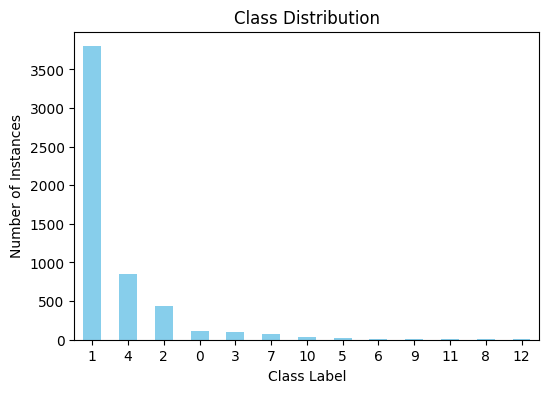


Class Proportions:
labels
1     0.691425
4     0.155289
2     0.079374
0     0.019479
3     0.018205
7     0.014564
10    0.007100
5     0.004369
6     0.002549
9     0.002549
11    0.002367
8     0.001456
12    0.001274
Name: count, dtype: float64


In [7]:
# CHECK CLASS DISTRIBUTION

import matplotlib.pyplot as plt

class_distribution = filtered_sentences_df["labels"].value_counts()

print("Class Distribution:")
print(class_distribution)

plt.figure(figsize=(6, 4))
class_distribution.plot(kind="bar", color="skyblue")
plt.title("Class Distribution")
plt.xlabel("Class Label")
plt.ylabel("Number of Instances")
plt.xticks(rotation=0)
plt.show()

class_proportions = class_distribution / len(filtered_sentences_df)
print("\nClass Proportions:")
print(class_proportions)

In [8]:
#  CREATE THE DATASET FOR THE TRAINING

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader, random_split

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

class EmailDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=64):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]["sentence"]
        labels = self.data.iloc[index]["labels"]

        encoding = self.tokenizer(text, truncation=True, padding="max_length", max_length=64, return_tensors="pt")

        labels_tensor = torch.tensor(labels, dtype=torch.float)
        return {
          "input_ids": encoding["input_ids"].squeeze(0),
          "attention_mask": encoding["attention_mask"].squeeze(0),
          "labels": labels_tensor
        }

dataset = EmailDataset(filtered_sentences_df, tokenizer, max_len=64)
sample = dataset[0]
print("Input IDs:", sample["input_ids"].shape)
print("Attention Mask:", sample["attention_mask"].shape)
print("Labels:", sample["labels"].shape)
print("Length of dataset:", len(dataset))
print(sample)

Input IDs: torch.Size([64])
Attention Mask: torch.Size([64])
Labels: torch.Size([])
Length of dataset: 5493
{'input_ids': tensor([  101,  2004,  2521,  2004,  1996,  2449,  6295,  1045,  2228,  2009,
         2052,  2022,  2062, 13318,  2000,  3046,  1998, 23216, 10287,  2408,
         1996,  2367,  2967,  2055,  2054,  2003,  2551,  1998,  2054,  2003,
         2025,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'labels': tensor(0.)}


In [9]:
# SPLIT THE DATASET INTO TRAIN AND TEST DATASETS

from sklearn.model_selection import train_test_split

filtered_sentences_df["labels"] = filtered_sentences_df["labels"].astype(int)

train_df, test_df = train_test_split(
    filtered_sentences_df,
    test_size=0.2,
    stratify=filtered_sentences_df["labels"],
    random_state=42
)

train_dataset = EmailDataset(train_df, tokenizer)
test_dataset = EmailDataset(test_df, tokenizer)

print("Train class distribution:\n", train_df["labels"].value_counts(normalize=True))
print("\nTest class distribution:\n", test_df["labels"].value_counts(normalize=True))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, pin_memory=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True, pin_memory=True, num_workers=2)

Train class distribution:
 labels
1     0.691397
4     0.155212
2     0.079426
0     0.019572
3     0.018207
7     0.014565
10    0.007055
5     0.004324
6     0.002503
9     0.002503
11    0.002276
8     0.001593
12    0.001365
Name: proportion, dtype: float64

Test class distribution:
 labels
1     0.691538
4     0.155596
2     0.079163
0     0.019108
3     0.018198
7     0.014559
10    0.007279
5     0.004550
9     0.002730
11    0.002730
6     0.002730
8     0.000910
12    0.000910
Name: proportion, dtype: float64


In [10]:
# MODEL CLASS FOR MULTI-LABEL CLASSIFICATION

import torch
import torch.nn as nn
import torch.optim as optim

class ArgumentMiningClassifier(nn.Module):
    def __init__(self):
        super(ArgumentMiningClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.fc = nn.Linear(self.bert.config.hidden_size, 13)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs.last_hidden_state[:, 0, :]
        return self.fc(cls_output)

In [14]:
# TRAIN THE MODEL

import torch
import numpy as np
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
scaler = GradScaler() if use_cuda else None

model = ArgumentMiningClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

class_counts = class_distribution.sort_index().values
total_samples = class_counts.sum()

class_weights = total_samples / (len(class_counts) * class_counts)

weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

criterion = torch.nn.CrossEntropyLoss(weight=weights_tensor)

def train_model(model, train_loader, criterion, optimizer, epochs=3, device='cpu'):
    model.to(device)
    print("Using device:", device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0

        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].long().to(device)

            optimizer.zero_grad()

            if use_cuda:
                with autocast():
                    outputs = model(input_ids, attention_mask)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()

            else:
                outputs = model(input_ids, attention_mask)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

train_model(model, train_loader, criterion, optimizer, device=device)

Using device: cpu
Epoch 1, Loss: 0.8268726985643976
Epoch 2, Loss: 0.13064806519781288
Epoch 3, Loss: 0.04757325501614221


Accuracy: 0.9691
Precision: 0.8867
Recall: 0.9182
F1-Score: 0.9009

Class 0 Confusion Matrix:
[[1077    1]
 [   0   21]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


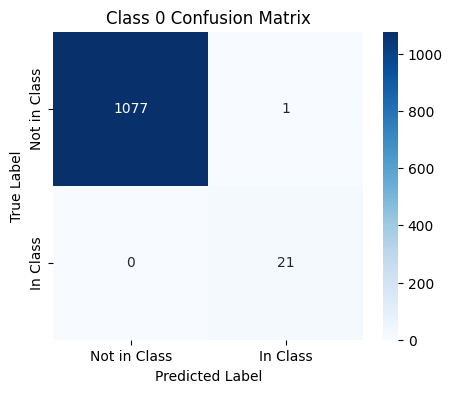


Class 1 Confusion Matrix:
[[337   2]
 [ 31 729]]


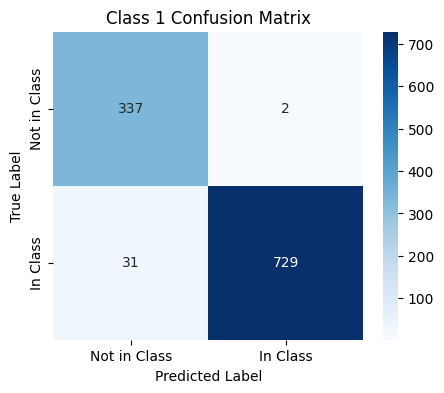


Class 2 Confusion Matrix:
[[983  29]
 [  2  85]]


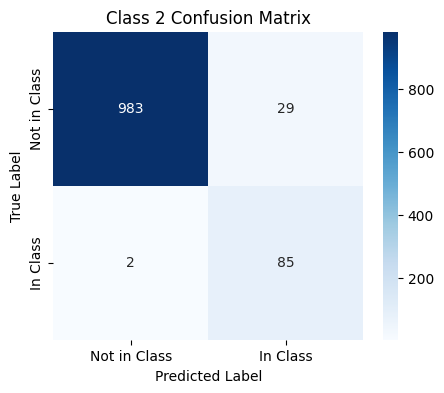


Class 3 Confusion Matrix:
[[1079    0]
 [   0   20]]


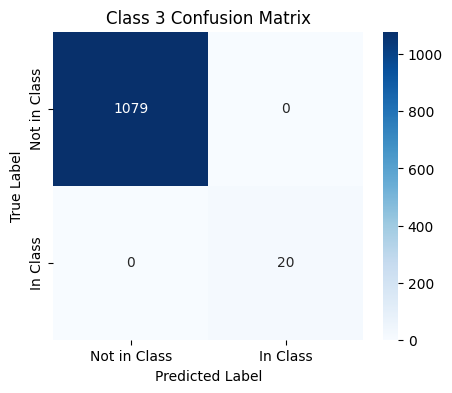


Class 4 Confusion Matrix:
[[928   0]
 [  0 171]]


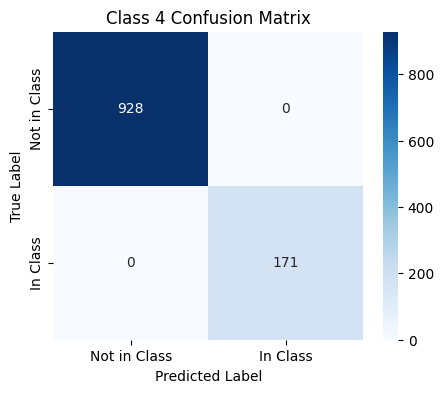


Class 5 Confusion Matrix:
[[1094    0]
 [   0    5]]


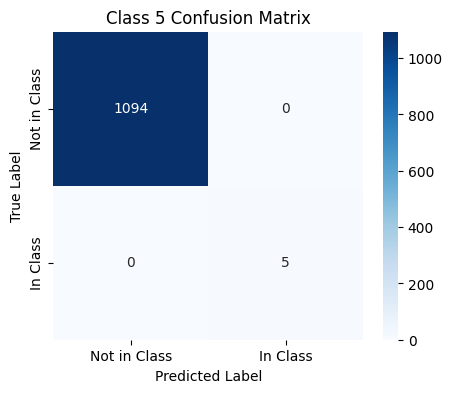


Class 6 Confusion Matrix:
[[1096    0]
 [   0    3]]


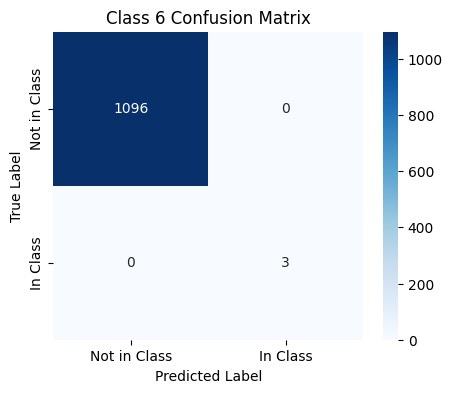


Class 7 Confusion Matrix:
[[1082    1]
 [   0   16]]


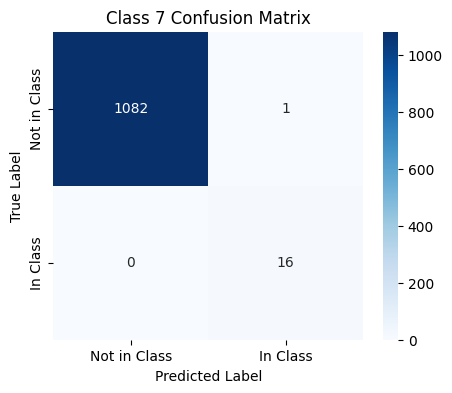


Class 8 Confusion Matrix:
[[1098    0]
 [   0    1]]


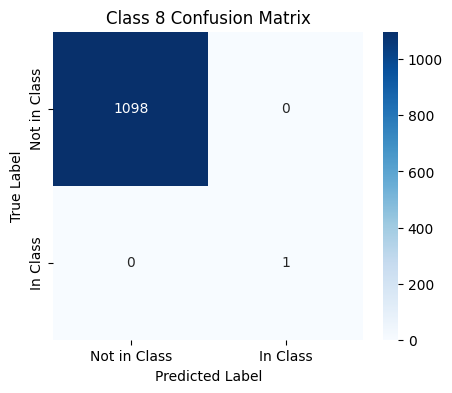


Class 9 Confusion Matrix:
[[1096    0]
 [   0    3]]


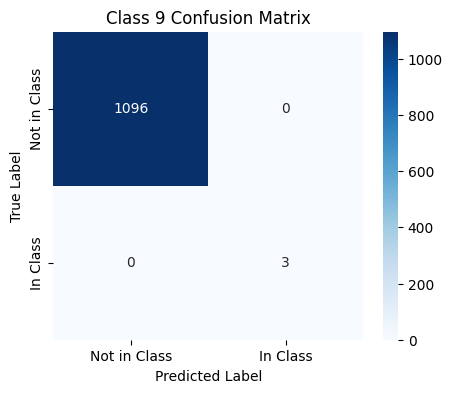


Class 10 Confusion Matrix:
[[1090    1]
 [   0    8]]


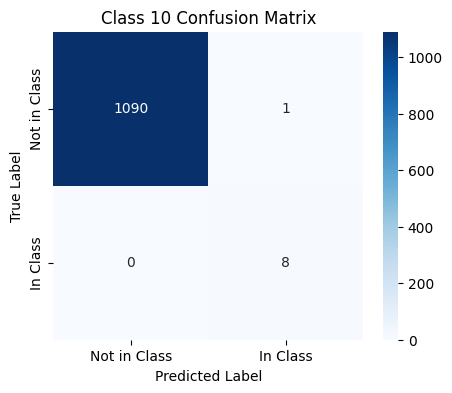


Class 11 Confusion Matrix:
[[1096    0]
 [   0    3]]


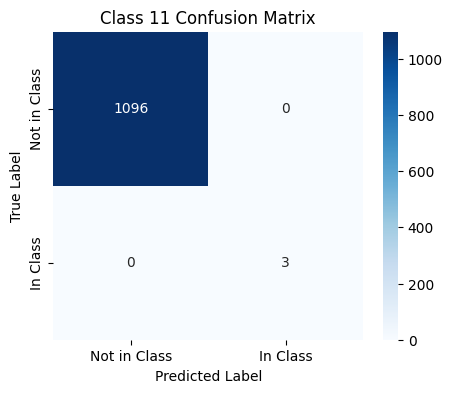


Class 12 Confusion Matrix:
[[1098    0]
 [   1    0]]


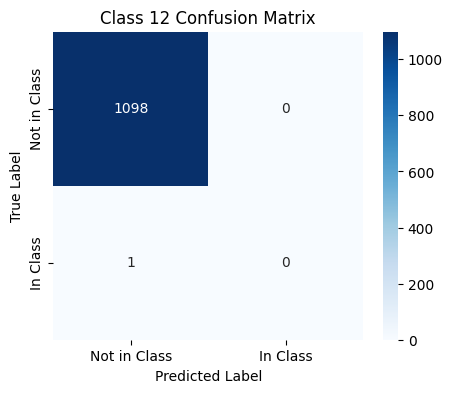

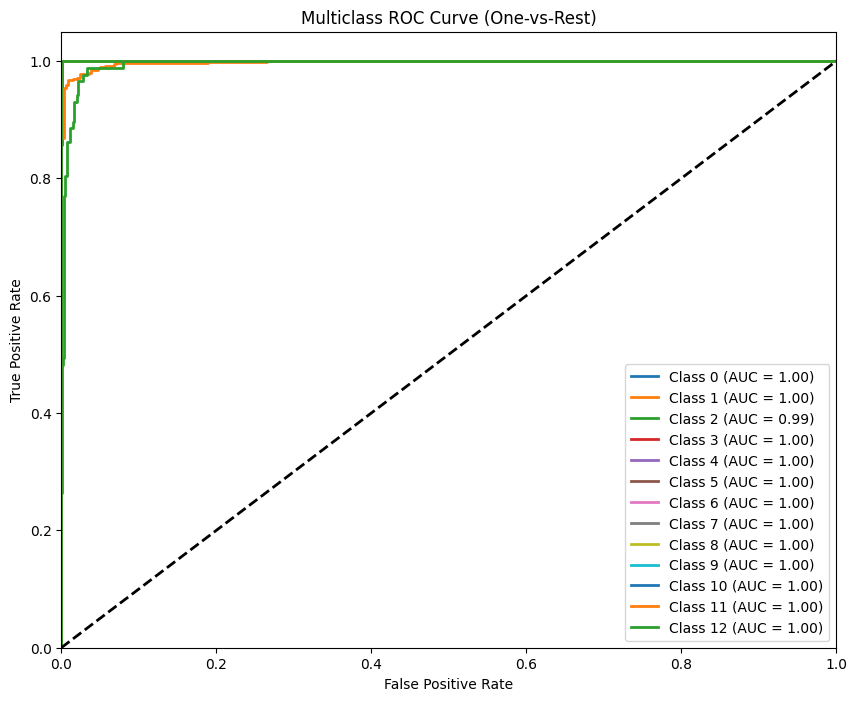

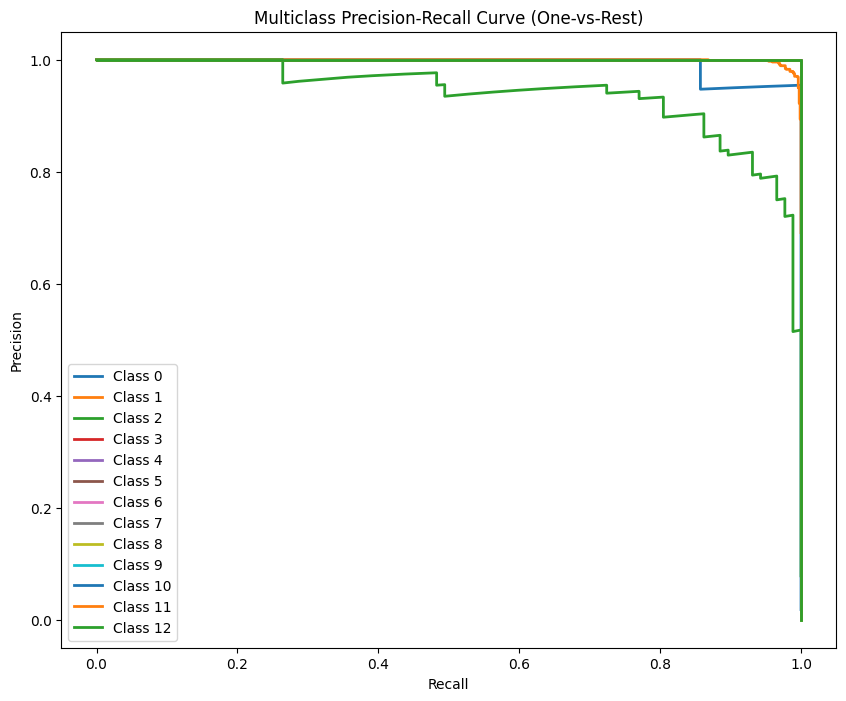

In [20]:
# MODEL EVALUATION

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

def plot_multiclass_roc(all_labels, all_probs, num_classes):
    all_labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))
    plt.figure(figsize=(10, 8))

    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multiclass ROC Curve (One-vs-Rest)')
    plt.legend(loc='lower right')
    plt.show()

def plot_multiclass_precision_recall(all_labels, all_probs, num_classes):
    all_labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))
    plt.figure(figsize=(10, 8))

    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(all_labels_bin[:, i], all_probs[:, i])
        plt.plot(recall, precision, lw=2, label=f'Class {i}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Multiclass Precision-Recall Curve (One-vs-Rest)')
    plt.legend(loc='lower left')
    plt.show()

def plot_confusion_matrix(cm, labels=None, title="Confusion Matrix"):
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels if labels else "auto",
                yticklabels=labels if labels else "auto")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.show()

def evaluate_model_with_plots(model, test_loader, device, num_classes):
    model.eval()
    all_labels = []
    all_predictions = []
    all_probs = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask)
            probs = torch.softmax(outputs, dim=1)
            _, predictions = torch.max(probs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    all_probs = np.array(all_probs)

    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions, average='macro')
    recall = recall_score(all_labels, all_predictions, average='macro')
    f1 = f1_score(all_labels, all_predictions, average='macro')
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    #plot_confusion_matrix(conf_matrix)

    for i in range(num_classes):
        binary_true = (all_labels == i).astype(int)
        binary_pred = (all_predictions == i).astype(int)
        cm = confusion_matrix(binary_true, binary_pred)
        print(f"\nClass {i} Confusion Matrix:\n{cm}")
        plot_confusion_matrix(cm, labels=["Not in Class", "In Class"], title=f"Class {i} Confusion Matrix")

    plot_multiclass_roc(all_labels, all_probs, num_classes)
    plot_multiclass_precision_recall(all_labels, all_probs, num_classes)

evaluate_model_with_plots(model, test_loader, device, num_classes=13)

In [19]:
# SAVE THE MODEL

torch.save(model.state_dict(), "/content/drive/My Drive/NLP/argument_classifier.pth")

In [12]:
# LOAD THE MODEL

from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader, random_split

model = ArgumentMiningClassifier()
model.load_state_dict(torch.load("/content/drive/My Drive/NLP/argument_classifier.pth"))
model.eval()

ArgumentMiningClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 